In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import random
import pandas as pd

from sklearn.model_selection import train_test_split , KFold
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import cross_val_score
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import tensorflow as tf


2025-06-10 17:15:05.204841: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-10 17:15:05.211659: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-10 17:15:05.225258: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749568505.245909  193256 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749568505.251956  193256 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749568505.268477  193256 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [3]:
# Load the dataset
raw_data = pd.read_csv('Single_EDFA_Dataset.csv')
raw_data.drop(columns=['measuredTotalPout'], inplace=True)
#raw_data.head(10)

#check for missing or null values
print(raw_data.isnull().sum())
# No missing values found

profileId           0
measuredTotalPin    0
inat152782          0
inat152829          0
inat152876          0
                   ..
outat156495         0
outat156542         0
outat156589         0
outat156636         0
outat156683         0
Length: 170, dtype: int64


In [4]:
def extract_features(data, one_every=1):
    """
    Extracts specific features from the input data based on column filtering.

    Parameters:
    - data (DataFrame): The input data containing multiple columns.
    - one_every (int): The step size for selecting columns from the 'inPot' range. 
                       Defaults to 1 (select all columns).

    Returns:
    - filtered (DataFrame): A filtered DataFrame containing selected columns:
        - The first two columns (head).
        - A subset of columns from 'inPot' based on the step size.
        - All columns from 'outPot'.
    - freq_chan (int): The number of columns selected from 'inPot' after filtering.
    """
    freq_chan = 84
    # Extract features from the data
    head = data.columns[:2]
    inPot = data.columns[2:2+freq_chan]
    outPot = data.columns[-freq_chan:]
    
    inPot = inPot[::one_every]

    filtered_columns = head.tolist() + inPot.tolist() + outPot.tolist()
    filtered = data[filtered_columns]

    freq_chan = len(inPot)

    return filtered, freq_chan


In [5]:
one_every = 1  # Change this to 1 to keep all channels or 2 to keep every other channel ...

data, freq_chan = extract_features(raw_data, one_every=1)

data.head(10)

profileId  measuredTotalPin  inat152782  inat152829  inat152876  \
0       1002          1.700000     -20.262     -19.152     -19.402   
1       1002          0.900000     -20.798     -19.688     -20.338   
2       1002         -0.046481     -21.227     -20.627     -21.417   
3       1002         -1.500000     -23.007     -22.307     -22.907   
4       1002         -2.600000     -24.132     -23.302     -23.952   
5       1002         -3.500000     -25.092     -24.212     -24.732   
6       1002         -4.500000     -26.080     -25.090     -26.150   
7       1002         -5.600000     -26.812     -26.222     -27.012   
8       1002         -6.600000     -28.153     -27.463     -27.823   
9      10030          1.900000     -24.745     -23.895     -24.565   

   inat152923  inat152970  inat153017  inat153064  inat153111  ...  \
0     -18.902     -19.052     -19.192     -19.172     -19.092  ...   
1     -19.888     -19.898     -19.918     -19.868     -19.838  ...   
2     -20.827     -20.847     -20.797     -20.807     -20.727  ...   
3     -22.247     -22.187     -22.367     -22.217     -22.137  ...   
4     -23.342     -23.122     -23.532     -23.632     -23.752  ...   
5     -24.542     -24.622     -24.582     -24.382     -24.202  ...   
6     -25.560     -25.410     -25.550     -25.580     -25.620  ...   
7     -26.592     -26.492     -26.922     -26.952     -27.142  ...   
8     -27.483     -27.543     -27.843     -28.023     -28.023  ...   
9     -24.085     -24.015     -24.265     -24.035     -23.795  ...   

   outat156260  outat156307  outat156354  outat156401  outat156448  \
0       -0.876       -0.896       -0.916       -0.936       -0.966   
1       -1.062       -1.142       -1.082       -1.142       -1.192   
2       -1.285       -1.275       -1.295       -1.375       -1.455   
3       -1.599       -1.589       -1.619       -1.759       -1.849   
4       -1.692       -1.842       -1.812       -1.982       -2.152   
5       -1.883       -2.073       -2.193       -2.313       -2.463   
6       -2.104       -2.304       -2.364       -2.654       -2.794   
7       -2.103       -2.333       -2.523       -2.733       -2.993   
8       -2.146       -2.436       -2.626       -2.906       -3.166   
9       -1.122       -1.252       -1.442       -1.682       -1.922   

   outat156495  outat156542  outat156589  outat156636  outat156683  
0       -0.846       -0.826       -1.136       -1.446       -2.486  
1       -1.162       -1.052       -1.212       -1.502       -2.752  
2       -1.385       -1.265       -1.365       -1.515       -2.945  
3       -1.819       -1.749       -1.849       -1.799       -3.219  
4       -2.142       -2.052       -2.052       -2.072       -3.272  
5       -2.493       -2.433       -2.443       -2.353       -3.433  
6       -2.764       -2.674       -2.664       -2.464       -3.644  
7       -3.073       -2.943       -2.843       -2.623       -3.673  
8       -3.276       -3.236       -3.156       -2.836       -3.766  
9       -1.942       -1.872       -2.092       -2.512       -3.932  

[10 rows x 170 columns]

In [6]:
def train_NN(X_tr, y_tr, activ, neur, lyrs):
    """
    Trains a neural network using K-Fold cross-validation and evaluates its performance.

    Parameters:
    - X_tr (array-like): Training features.
    - y_tr (array-like): Training target values.
    - activ (str): Activation function to use in the hidden layers (e.g., 'relu', 'sigmoid').
    - neur (int): Number of neurons per hidden layer.
    - lyrs (int): Number of hidden layers in the neural network.

    Returns:
    - model (Sequential): The trained neural network model.
    - training_time (float): Total time taken for training the model (5 times).
    - avg_scores (list): Average performance metrics across folds:
        - Mean Squared Error (MSE).
        - Mean Absolute Error (MAE).
        - R-squared (R2).
    """
    print('Training a NN...')
    print(f'Activation function: {activ}, Neurons per layer: {neur}, Number of layers: {lyrs}')

    # Kfold k = 5
    kf = KFold(n_splits=5, shuffle=True, random_state=42) 
    
    mae = []
    mse = []
    r2 = []
    start_time = time.time()
    for train_index, test_index in kf.split(X_tr, y_tr):
        X_train_fold, X_test_fold = X_tr[train_index], X_tr[test_index]
        y_train_fold, y_test_fold = y_tr.iloc[train_index], y_tr.iloc[test_index]

        # Create a neural network regressor
        model = Sequential()
        model.add(Input(shape=(X_train_fold.shape[1],)))
        # Add hidden layers
        for _ in range(lyrs):
            model.add(Dense(neur, activation=activ))        
        # Add the output layer
        model.add(Dense(84))  # 84 outputs, one per channel
        model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'r2_score'])
        print(X_train_fold.shape, y_train_fold.shape)
        model.fit(X_train_fold, y_train_fold, epochs=15, batch_size=32, validation_split=0.2, verbose=0)
    
        scores = model.evaluate(X_test_fold, y_test_fold, verbose=0)
        mse.append(scores[1])
        mae.append(scores[2])
        r2.append(scores[3])
        print(f'Fold Number {len(mse)}: MSE = {mse[-1]:.4f}, MAE = {mae[-1]:.4f}, R2 = {r2[-1]:.4f}')

    avg_mse = np.mean(mse)
    avg_mae = np.mean(mae)
    avg_r2 = np.mean(r2)
    
    print(f'Average MSE: {avg_mse:.4f}, Average MAE: {avg_mae:.4f}, Average R2: {avg_r2:.4f}')

    avg_scores = [avg_mse, avg_mae, avg_r2]

    training_time = time.time() - start_time # Note: this is the time for 5 folds

    #plt.savefig('Results/training_loss_curve_'+solv_name+'.png')
    
    return model, training_time, avg_scores



In [7]:
activation = ['relu', 'tanh', 'sigmoid', 'linear'] #
neurons = [16, 32, 64, 128]
layers = [1, 2, 3]

X = data[data.columns[1:2+freq_chan]]
y = data[data.columns[-84:]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize t.tolist()he data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)


In [7]:
display(X_train)
print(freq_chan)

measuredTotalPin  inat152782  inat152829  inat152876  inat152923  \
10652              -3.5     -21.636     -21.656     -21.536     -21.156   
10003              -2.8     -28.584     -28.454     -28.104     -28.324   
4153               -2.5     -23.141     -22.591     -23.041     -22.411   
11427              -4.7     -23.093     -22.753     -22.723     -22.703   
5903               -6.4     -34.301     -33.451     -33.401     -32.661   
...                 ...         ...         ...         ...         ...   
11284              -5.3     -24.203     -23.973     -23.783     -23.943   
11964              -1.5     -21.393     -21.203     -21.773     -21.083   
5390               -6.0     -27.165     -26.015     -26.235     -25.245   
860                -3.6     -23.242     -22.612     -23.122     -22.452   
15795               1.6     -19.074     -18.814     -18.894     -18.164   

       inat152970  inat153017  inat153064  inat153111  inat153158  ...  \
10652     -20.796     -20.776     -20.736     -20.856     -20.726  ...   
10003     -27.824     -28.404     -28.304     -28.784     -28.284  ...   
4153      -22.411     -22.441     -22.331     -22.281     -22.471  ...   
11427     -22.053     -22.493     -22.233     -22.623     -22.513  ...   
5903      -32.631     -34.161     -34.211     -34.131     -35.041  ...   
...           ...         ...         ...         ...         ...  ...   
11284     -23.893     -24.123     -23.853     -23.943     -23.903  ...   
11964     -21.153     -21.093     -21.193     -21.203     -21.313  ...   
5390      -25.005     -24.735     -24.415     -23.955     -23.715  ...   
860       -22.392     -22.382     -22.312     -22.422     -22.612  ...   
15795     -18.334     -18.534     -18.514     -18.424     -18.634  ...   

       inat156260  inat156307  inat156354  inat156401  inat156448  inat156495  \
10652     -25.666     -25.876     -25.946     -26.456     -26.606     -26.746   
10003     -18.594     -18.414     -17.984     -17.354     -16.874     -16.584   
4153      -21.521     -21.431     -21.381     -21.271     -21.181     -21.011   
11427     -23.803     -23.863     -23.633     -23.513     -23.433     -23.113   
5903      -22.771     -22.601     -22.291     -22.031     -21.541     -20.701   
...           ...         ...         ...         ...         ...         ...   
11284     -26.113     -26.473     -26.583     -26.893     -27.023     -27.093   
11964     -20.373     -20.253     -20.063     -19.973     -19.873     -19.723   
5390      -26.315     -26.275     -26.445     -26.755     -26.995     -27.325   
860       -23.352     -23.382     -23.342     -23.352     -23.332     -23.192   
15795     -16.974     -16.984     -16.924     -16.844     -16.824     -16.694   

       inat156542  inat156589  inat156636  inat156683  
10652     -26.886     -27.126     -27.046     -26.836  
10003     -16.544     -16.794     -17.054     -17.904  
4153      -20.791     -20.621     -20.271     -20.381  
11427     -22.833     -22.573     -22.203     -22.413  
5903      -19.991     -19.731     -19.641     -20.391  
...           ...         ...         ...         ...  
11284     -27.063     -27.093     -26.853     -26.643  
11964     -19.423     -19.293     -18.933     -19.233  
5390      -27.545     -27.775     -27.645     -27.255  
860       -22.982     -22.892     -22.532     -22.202  
15795     -16.524     -16.514     -16.444     -16.694  

[13197 rows x 85 columns]

84


In [ ]:
# ------------- DON'T RUN THIS AGAIN -------------
# RESULTS ARE IN hp_opt_metrics/parameters_one_every_X.csv

# Better to run this in smaller chunks to avoid long processing times... and to blow my pc up :)
for one_every in [1, 2, 3, 5, 10]: #1, 2, 3, 5, 10 
    with open(f'hp_opt_metrics/parameters_one_every_{one_every}.csv', 'w') as f:
        f.write(f"Activation,Neurons,Layers,MSE,MAE,R2,Training Time\n")
    
    # Prepare the data for the current one_every
    print(f'Processing with one_every={one_every}...')
    X_temp, freq_chan = extract_features(raw_data, one_every=one_every)
    X = X_temp[X_temp.columns[1:2+freq_chan]] 
    y = X_temp[X_temp.columns[-84:]]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    # Normalize the data
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)

    # Loop through hyperparameters and train the model
    for activ in activation:
        for neur in neurons:
            for lyrs in layers:
                model, training_time, metrics = train_NN(X_train_std, y_train, activ, neur, lyrs)
                with open(f'hp_opt_metrics/parameters_one_every_{one_every}.csv', 'a') as f:
                    f.write(f"{activ},{neur},{lyrs},{metrics[0]},{metrics[1]},{metrics[2]},{training_time}\n")

Processing with one_every=10...
(13197, 10) (3300, 10) (13197, 84) (3300, 84)
Training a NN...
Activation function: relu, Neurons per layer: 16, Number of layers: 1
(10557, 10) (10557, 84)
Fold Number 1: MSE = 0.2467, MAE = 0.3370, R2 = 0.9391
(10557, 10) (10557, 84)
Fold Number 2: MSE = 0.2733, MAE = 0.3484, R2 = 0.9371
(10558, 10) (10558, 84)
Fold Number 3: MSE = 0.2577, MAE = 0.3486, R2 = 0.9377
(10558, 10) (10558, 84)
Fold Number 4: MSE = 0.2584, MAE = 0.3475, R2 = 0.9336
(10558, 10) (10558, 84)
Fold Number 5: MSE = 0.2749, MAE = 0.3591, R2 = 0.9353
Average MSE: 0.2622, Average MAE: 0.3481, Average R2: 0.9366
Training a NN...
Activation function: relu, Neurons per layer: 16, Number of layers: 2
(10557, 10) (10557, 84)
Fold Number 1: MSE = 0.1943, MAE = 0.2980, R2 = 0.9510
(10557, 10) (10557, 84)
Fold Number 2: MSE = 0.2095, MAE = 0.3044, R2 = 0.9446
(10558, 10) (10558, 84)
Fold Number 3: MSE = 0.2308, MAE = 0.3205, R2 = 0.9437
(10558, 10) (10558, 84)
Fold Number 4: MSE = 0.2080, MA

In [8]:
best_parameters = {}  # Dictionary to store the best parameters for each one_every value

for one_every in [1, 2, 3, 5, 10]:
    best_parameters[f'one_every_{one_every}'] = {'activation': 'Topo gigio',
                                                    'neurons': -1,
                                                    'layers': -1,
                                                    'mse': 999,
                                                    'mae': 999,
                                                    'r2': -999,
                                                    'training_time': 0
                                                    }               
    for line in open(f'hp_opt_metrics/parameters_one_every_{one_every}.csv').readlines()[1:]:
        activ, neur, lyrs, mse, mae, r2, training_time = line.strip().split(',')
        neur = int(neur)
        lyrs = int(lyrs)
        mse = float(mse)
        mae = float(mae)
        r2 = float(r2)
        training_time = float(training_time)

        # Check if the current parameters yield a better score
        if mse < best_parameters[f'one_every_{one_every}']['mse']:
            best_parameters[f'one_every_{one_every}']['activation'] = activ
            best_parameters[f'one_every_{one_every}']['neurons'] = neur
            best_parameters[f'one_every_{one_every}']['layers'] = lyrs
            best_parameters[f'one_every_{one_every}']['mse'] = mse
            best_parameters[f'one_every_{one_every}']['mae'] = mae
            best_parameters[f'one_every_{one_every}']['r2'] = r2
            best_parameters[f'one_every_{one_every}']['training_time'] = training_time

In [9]:
best_parameters

{'one_every_1': {'activation': 'relu',
  'neurons': 128,
  'layers': 2,
  'mse': 0.04199244976043701,
  'mae': 0.14574085175991058,
  'r2': 0.9902734756469727,
  'training_time': 48.48757553100586},
 'one_every_2': {'activation': 'relu',
  'neurons': 128,
  'layers': 2,
  'mse': 0.04206980913877487,
  'mae': 0.14629900455474854,
  'r2': 0.9901654839515686,
  'training_time': 49.581499338150024},
 'one_every_3': {'activation': 'relu',
  'neurons': 128,
  'layers': 2,
  'mse': 0.042020737379789355,
  'mae': 0.144916632771492,
  'r2': 0.9900793552398681,
  'training_time': 49.274423360824585},
 'one_every_5': {'activation': 'relu',
  'neurons': 128,
  'layers': 2,
  'mse': 0.04840897172689438,
  'mae': 0.15454070568084716,
  'r2': 0.9888771414756775,
  'training_time': 48.81384992599487},
 'one_every_10': {'activation': 'relu',
  'neurons': 128,
  'layers': 3,
  'mse': 0.07828130573034286,
  'mae': 0.19334785044193267,
  'r2': 0.9823666930198669,
  'training_time': 48.9149866104126}}

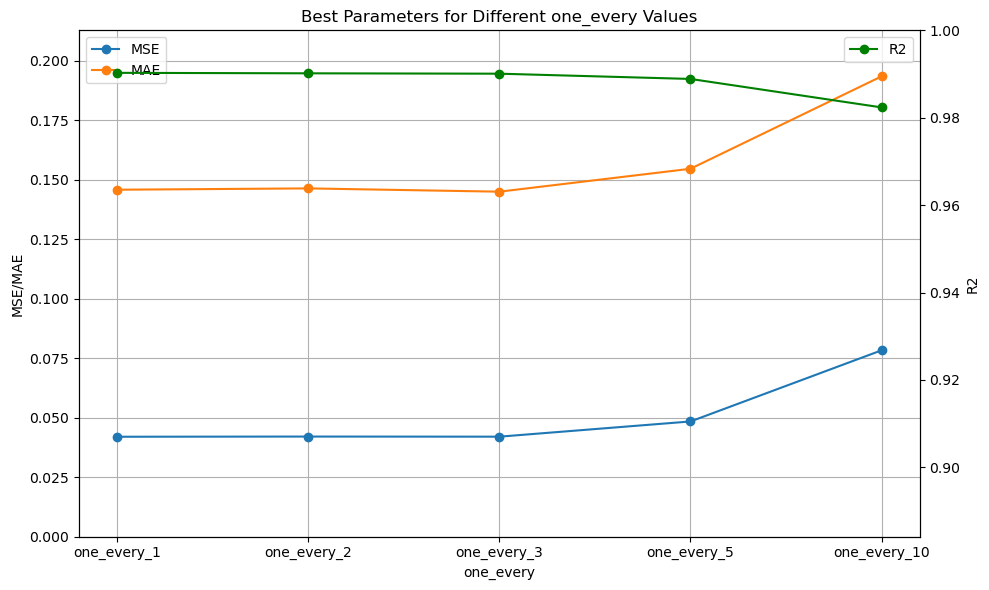

In [10]:
# Plot best parameters
fig, ax = plt.subplots(figsize=(10, 6))
one_every_values = list(best_parameters.keys())

mse_values = [best_parameters[oe]['mse'] for oe in one_every_values]
ax.plot(one_every_values, mse_values, marker='o', label='MSE')
mae_values = [best_parameters[oe]['mae'] for oe in one_every_values]
ax.plot(one_every_values, mae_values, marker='o', label='MAE')
r2_values = [best_parameters[oe]['r2'] for oe in one_every_values]

# 2 different y axes (1 for mse/mae and 1 for r2)
ax.set_xlabel('one_every')
ax.set_ylabel('MSE/MAE')
ax.set_ylim(0, max(max(mse_values), max(mae_values)) * 1.1)
ax2 = ax.twinx()
ax2.set_ylabel('R2')
ax2.set_ylim(min(r2_values) * 0.9, 1.0)  # R2 is between -1 and 1, so we set limits accordingly
ax2.plot(one_every_values, r2_values, marker='o', color='green', label='R2')
ax.set_title('Best Parameters for Different one_every Values')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
ax.grid()
plt.tight_layout()
# Save the best parameters to a CSV file
    

Best parameters for one_every=1: {'activation': 'relu', 'neurons': 128, 'layers': 2, 'mse': 0.04199244976043701, 'mae': 0.14574085175991058, 'r2': 0.9902734756469727, 'training_time': 48.48757553100586}
Training a NN...
Activation function: relu, Neurons per layer: 128, Number of layers: 2
(10557, 85) (10557, 84)


2025-06-10 17:15:14.172423: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Fold Number 1: MSE = 0.0432, MAE = 0.1514, R2 = 0.9902
(10557, 85) (10557, 84)
Fold Number 2: MSE = 0.0438, MAE = 0.1532, R2 = 0.9897
(10558, 85) (10558, 84)
Fold Number 3: MSE = 0.0437, MAE = 0.1495, R2 = 0.9897
(10558, 85) (10558, 84)
Fold Number 4: MSE = 0.0404, MAE = 0.1435, R2 = 0.9899
(10558, 85) (10558, 84)
Fold Number 5: MSE = 0.0392, MAE = 0.1416, R2 = 0.9908
Average MSE: 0.0420, Average MAE: 0.1479, Average R2: 0.9900
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


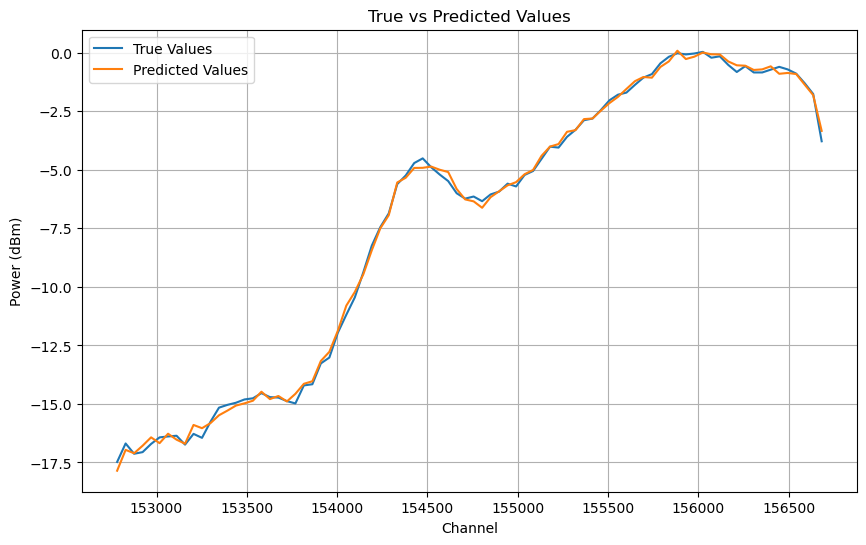

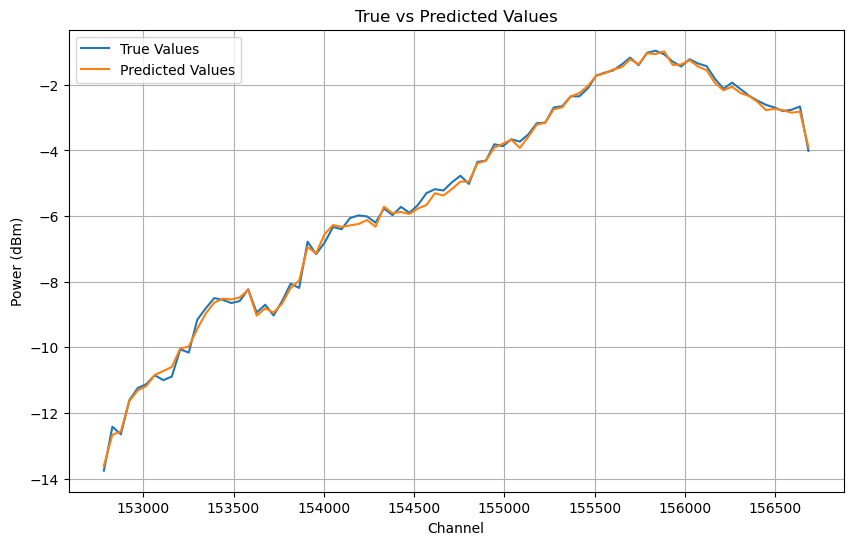

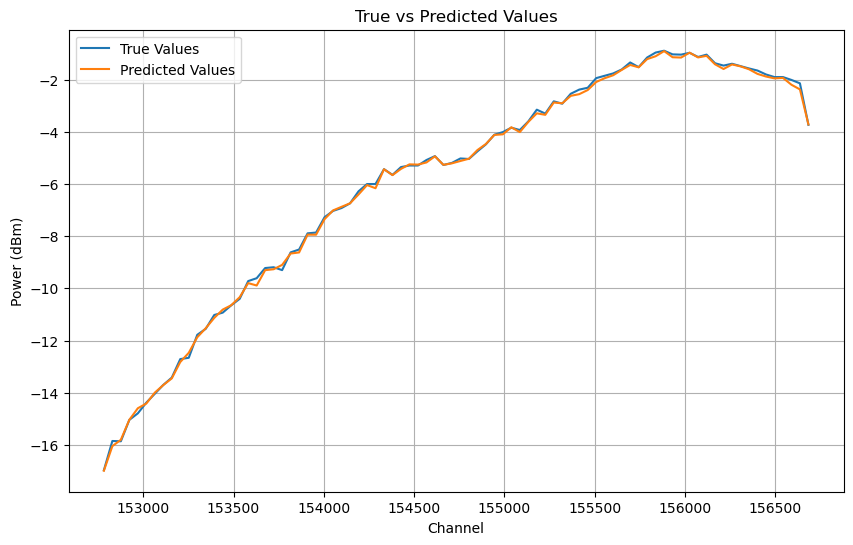

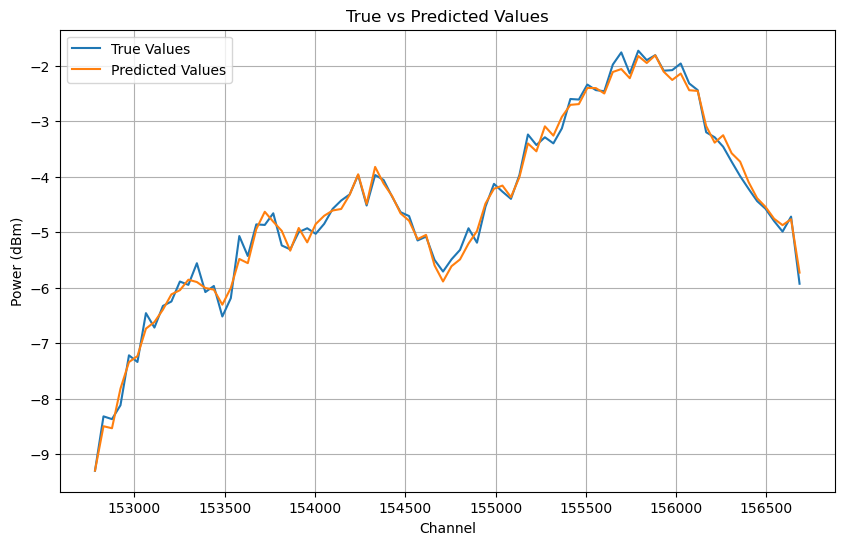

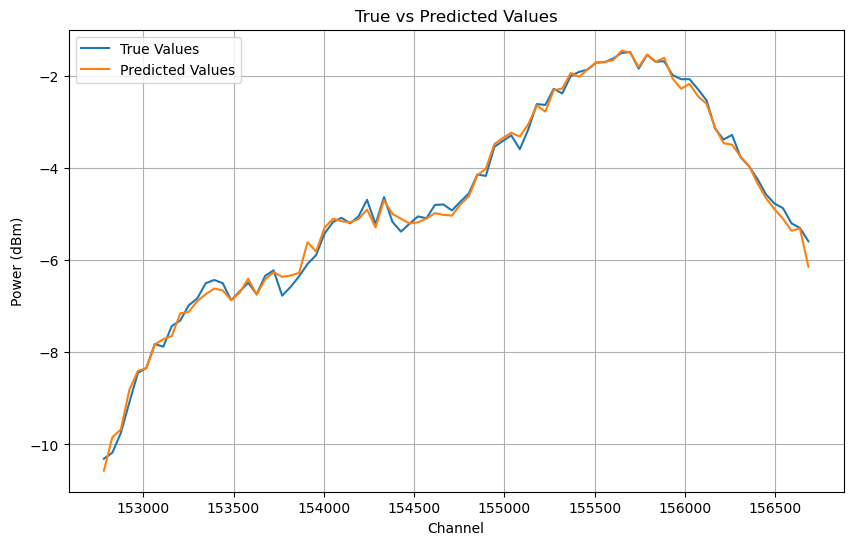

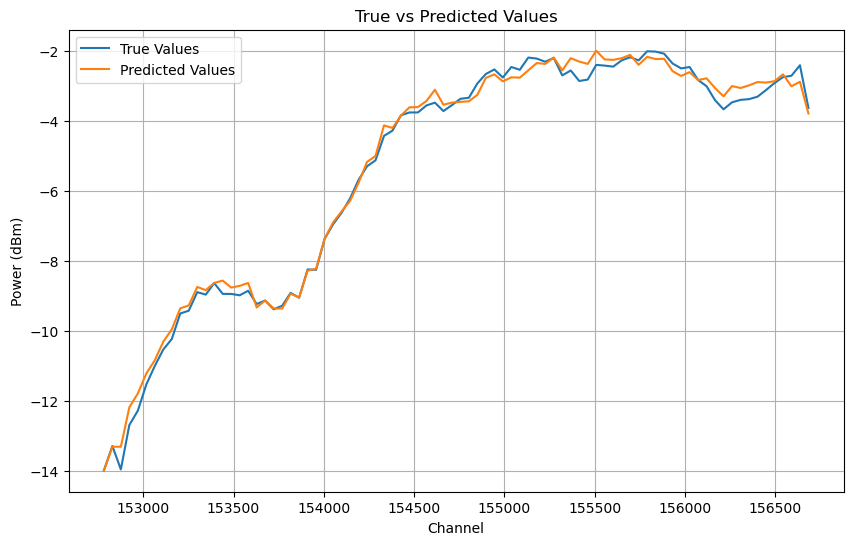

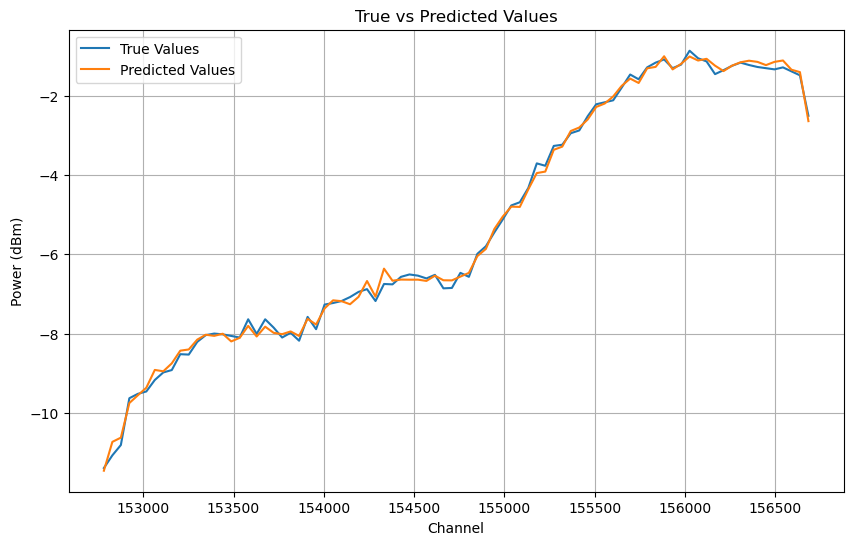

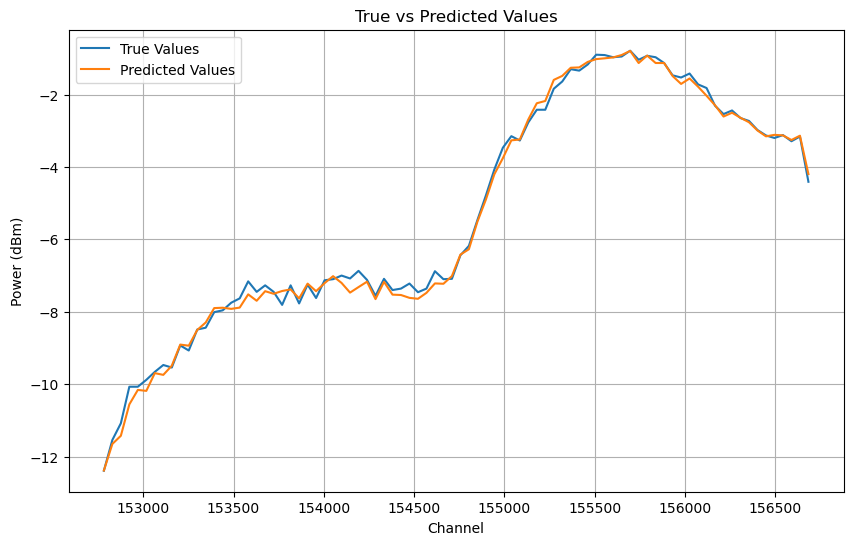

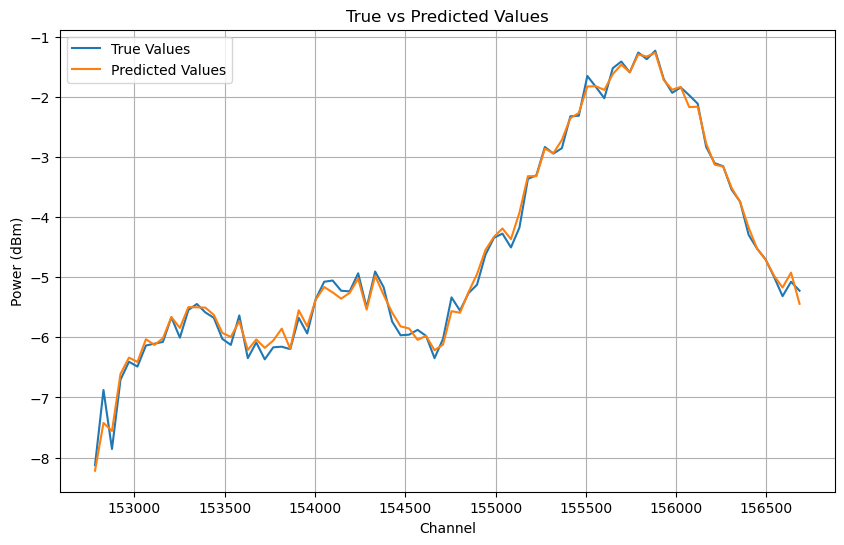

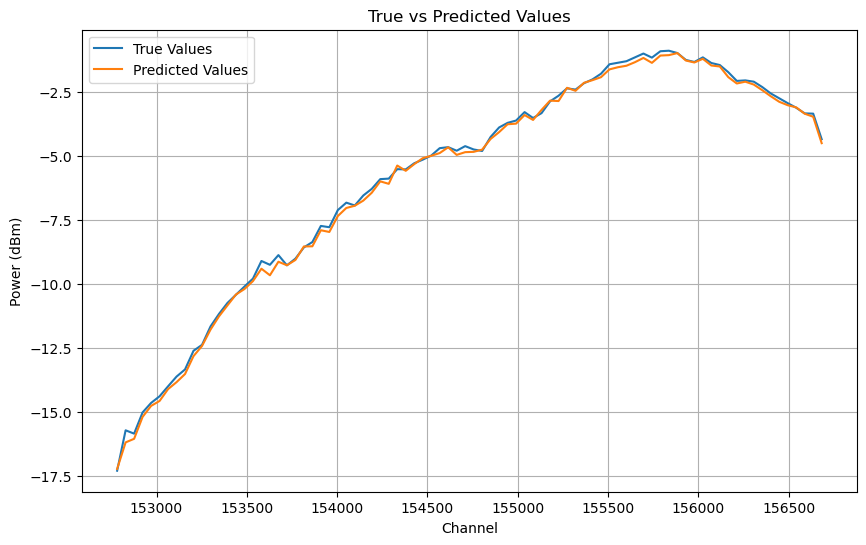

In [11]:
min_freq = 152782
max_freq = 156683

freqs = np.linspace(min_freq, max_freq, 84)

# Use the best parameters found
best_one_every = 1  # Change this to the best one_every found
best_params = best_parameters[f'one_every_{best_one_every}']
print(f'Best parameters for one_every={best_one_every}: {best_params}')

X_temp, freq_chan = extract_features(raw_data, one_every=best_one_every)
X = X_temp[X_temp.columns[1:2+freq_chan]]
y = X_temp[X_temp.columns[-84:]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

model, training_time, metrics = train_NN(X_train_std, y_train, 
                                        best_params['activation'], 
                                        best_params['neurons'], 
                                        best_params['layers'])

# Make predictions
y_pred = model.predict(X_test_std)
# Convert predictions to DataFrame for easier plotting
y_pred = pd.DataFrame(y_pred, columns=y_test.columns)
for idx in range(10): #y_test.shape[0]X_tr[train_index], X_tr[test_index]
    #Plot
    plt.figure(figsize=(10, 6))
    plt.plot(freqs, y_test.iloc[idx], label='True Values')
    plt.plot(freqs, y_pred.iloc[idx], label='Predicted Values')
    plt.title('True vs Predicted Values')
    plt.xlabel('Channel')
    plt.ylabel('Power (dBm)')
    plt.legend()
    plt.grid()
    plt.show()

In [27]:
display(y)
print(freq_chan)

outat152782  outat152829  outat152876  outat152923  outat152970  \
0          -18.736      -17.176      -16.996      -16.116      -15.856   
1          -17.462      -15.902      -16.152      -15.302      -14.902   
2          -15.955      -14.875      -15.225      -14.225      -13.875   
3          -14.989      -13.799      -13.949      -12.859      -12.579   
4          -14.292      -12.942      -13.162      -12.062      -11.612   
...            ...          ...          ...          ...          ...   
16492      -11.438      -10.788      -11.028       -9.968       -9.728   
16493      -11.105      -10.165      -10.365       -9.455       -9.005   
16494      -10.572       -9.582       -9.842       -9.172       -8.942   
16495       -9.912       -8.852       -9.602       -8.412       -8.132   
16496       -9.019       -8.269       -8.619       -7.679       -7.429   

       outat153017  outat153064  outat153111  outat153158  outat153205  ...  \
0          -15.616      -15.196      -14.746      -14.536      -13.786  ...   
1          -14.552      -14.142      -13.752      -13.432      -12.792  ...   
2          -13.475      -13.095      -12.735      -12.505      -11.625  ...   
3          -12.359      -11.799      -11.439      -11.449      -10.709  ...   
4          -11.682      -11.432      -11.282      -11.222      -10.582  ...   
...            ...          ...          ...          ...          ...  ...   
16492       -9.418       -8.978       -8.688       -8.548       -7.968  ...   
16493       -9.335       -8.995       -8.765       -8.675       -8.085  ...   
16494       -8.572       -8.072       -7.802       -7.682       -7.132  ...   
16495       -7.962       -7.642       -7.362       -7.142       -6.522  ...   
16496       -7.549       -7.179       -7.079       -6.899       -6.359  ...   

       outat156260  outat156307  outat156354  outat156401  outat156448  \
0           -0.876       -0.896       -0.916       -0.936       -0.966   
1           -1.062       -1.142       -1.082       -1.142       -1.192   
2           -1.285       -1.275       -1.295       -1.375       -1.455   
3           -1.599       -1.589       -1.619       -1.759       -1.849   
4           -1.692       -1.842       -1.812       -1.982       -2.152   
...            ...          ...          ...          ...          ...   
16492       -3.938       -4.078       -4.128       -4.208       -4.258   
16493       -4.145       -4.345       -4.385       -4.565       -4.505   
16494       -4.142       -4.492       -4.612       -4.792       -4.772   
16495       -4.382       -4.802       -4.802       -5.152       -5.152   
16496       -4.369       -4.559       -4.769       -5.269       -5.289   

       outat156495  outat156542  outat156589  outat156636  outat156683  
0           -0.846       -0.826       -1.136       -1.446       -2.486  
1           -1.162       -1.052       -1.212       -1.502       -2.752  
2           -1.385       -1.265       -1.365       -1.515       -2.945  
3           -1.819       -1.749       -1.849       -1.799       -3.219  
4           -2.142       -2.052       -2.052       -2.072       -3.272  
...            ...          ...          ...          ...          ...  
16492       -4.028       -4.018       -4.198       -4.138       -5.968  
16493       -4.465       -4.335       -4.535       -4.565       -6.455  
16494       -4.762       -4.832       -4.862       -4.772       -6.812  
16495       -5.092       -5.142       -5.292       -5.182       -7.162  
16496       -5.289       -5.369       -5.619       -5.499       -7.289  

[16497 rows x 84 columns]

84


535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step


PermutationExplainer explainer:   3%|▎         | 3/100 [00:00<?, ?it/s]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step


PermutationExplainer explainer:   5%|▌         | 5/100 [00:12<01:23,  1.14it/s]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step


PermutationExplainer explainer:   6%|▌         | 6/100 [00:14<01:59,  1.27s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step


PermutationExplainer explainer:   7%|▋         | 7/100 [00:16<02:15,  1.46s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step


PermutationExplainer explainer:   8%|▊         | 8/100 [00:17<02:25,  1.58s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step


PermutationExplainer explainer:   9%|▉         | 9/100 [00:19<02:28,  1.63s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 937us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step


PermutationExplainer explainer:  10%|█         | 10/100 [00:21<02:31,  1.68s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step


PermutationExplainer explainer:  11%|█         | 11/100 [00:23<02:30,  1.69s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 984us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


PermutationExplainer explainer:  12%|█▏        | 12/100 [00:24<02:28,  1.69s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step


PermutationExplainer explainer:  13%|█▎        | 13/100 [00:26<02:27,  1.69s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  14%|█▍        | 14/100 [00:28<02:37,  1.83s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step


PermutationExplainer explainer:  15%|█▌        | 15/100 [00:30<02:34,  1.82s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step


PermutationExplainer explainer:  16%|█▌        | 16/100 [00:32<02:26,  1.74s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step


PermutationExplainer explainer:  17%|█▋        | 17/100 [00:33<02:21,  1.70s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step


PermutationExplainer explainer:  18%|█▊        | 18/100 [00:35<02:27,  1.80s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step


PermutationExplainer explainer:  19%|█▉        | 19/100 [00:37<02:19,  1.72s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:  20%|██        | 20/100 [00:38<02:16,  1.71s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


PermutationExplainer explainer:  21%|██        | 21/100 [00:40<02:10,  1.66s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


PermutationExplainer explainer:  22%|██▏       | 22/100 [00:41<02:06,  1.62s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step


PermutationExplainer explainer:  23%|██▎       | 23/100 [00:43<02:03,  1.60s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step


PermutationExplainer explainer:  24%|██▍       | 24/100 [00:45<02:00,  1.58s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  25%|██▌       | 25/100 [00:46<02:04,  1.66s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step


PermutationExplainer explainer:  26%|██▌       | 26/100 [00:48<02:00,  1.62s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


PermutationExplainer explainer:  27%|██▋       | 27/100 [00:49<01:55,  1.58s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step


PermutationExplainer explainer:  28%|██▊       | 28/100 [00:51<01:54,  1.59s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step


PermutationExplainer explainer:  29%|██▉       | 29/100 [00:53<01:53,  1.59s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step


PermutationExplainer explainer:  30%|███       | 30/100 [00:54<01:48,  1.55s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step


PermutationExplainer explainer:  31%|███       | 31/100 [00:55<01:44,  1.51s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step


PermutationExplainer explainer:  32%|███▏      | 32/100 [00:57<01:41,  1.50s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step


PermutationExplainer explainer:  33%|███▎      | 33/100 [00:58<01:38,  1.47s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step


PermutationExplainer explainer:  34%|███▍      | 34/100 [01:00<01:36,  1.47s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step


PermutationExplainer explainer:  35%|███▌      | 35/100 [01:01<01:33,  1.44s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step


PermutationExplainer explainer:  36%|███▌      | 36/100 [01:03<01:32,  1.44s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step


PermutationExplainer explainer:  37%|███▋      | 37/100 [01:04<01:30,  1.43s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step


PermutationExplainer explainer:  38%|███▊      | 38/100 [01:06<01:29,  1.44s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step


PermutationExplainer explainer:  39%|███▉      | 39/100 [01:07<01:27,  1.43s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step


PermutationExplainer explainer:  40%|████      | 40/100 [01:08<01:26,  1.44s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step


PermutationExplainer explainer:  41%|████      | 41/100 [01:10<01:24,  1.44s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step


PermutationExplainer explainer:  42%|████▏     | 42/100 [01:11<01:23,  1.44s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step


PermutationExplainer explainer:  43%|████▎     | 43/100 [01:13<01:21,  1.43s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step


PermutationExplainer explainer:  44%|████▍     | 44/100 [01:14<01:20,  1.44s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


PermutationExplainer explainer:  45%|████▌     | 45/100 [01:16<01:18,  1.43s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step


PermutationExplainer explainer:  46%|████▌     | 46/100 [01:17<01:16,  1.42s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step


PermutationExplainer explainer:  47%|████▋     | 47/100 [01:18<01:15,  1.43s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step


PermutationExplainer explainer:  48%|████▊     | 48/100 [01:20<01:14,  1.43s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 977us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step


PermutationExplainer explainer:  49%|████▉     | 49/100 [01:22<01:18,  1.53s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  50%|█████     | 50/100 [01:24<01:28,  1.77s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 944us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  51%|█████     | 51/100 [01:26<01:31,  1.87s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 964us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step


PermutationExplainer explainer:  52%|█████▏    | 52/100 [01:28<01:28,  1.84s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 926us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step


PermutationExplainer explainer:  53%|█████▎    | 53/100 [01:30<01:26,  1.84s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


PermutationExplainer explainer:  54%|█████▍    | 54/100 [01:31<01:22,  1.80s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step


PermutationExplainer explainer:  55%|█████▌    | 55/100 [01:33<01:17,  1.72s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step


PermutationExplainer explainer:  56%|█████▌    | 56/100 [01:35<01:14,  1.70s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


PermutationExplainer explainer:  57%|█████▋    | 57/100 [01:37<01:20,  1.86s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step


PermutationExplainer explainer:  58%|█████▊    | 58/100 [01:38<01:15,  1.81s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step


PermutationExplainer explainer:  59%|█████▉    | 59/100 [01:40<01:13,  1.78s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 987us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  60%|██████    | 60/100 [01:43<01:18,  1.96s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step


PermutationExplainer explainer:  61%|██████    | 61/100 [01:45<01:19,  2.03s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  62%|██████▏   | 62/100 [01:47<01:15,  2.00s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step


PermutationExplainer explainer:  63%|██████▎   | 63/100 [01:49<01:15,  2.04s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 921us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step


PermutationExplainer explainer:  64%|██████▍   | 64/100 [01:50<01:09,  1.94s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  65%|██████▌   | 65/100 [01:52<01:04,  1.84s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 955us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  66%|██████▌   | 66/100 [01:54<01:02,  1.85s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step


PermutationExplainer explainer:  67%|██████▋   | 67/100 [01:56<00:58,  1.78s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step


PermutationExplainer explainer:  68%|██████▊   | 68/100 [01:57<00:55,  1.72s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step


PermutationExplainer explainer:  69%|██████▉   | 69/100 [01:59<00:54,  1.77s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step


PermutationExplainer explainer:  70%|███████   | 70/100 [02:01<00:53,  1.79s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 993us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step


PermutationExplainer explainer:  71%|███████   | 71/100 [02:03<00:51,  1.78s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step


PermutationExplainer explainer:  72%|███████▏  | 72/100 [02:05<00:53,  1.92s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 993us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step


PermutationExplainer explainer:  73%|███████▎  | 73/100 [02:07<00:53,  2.00s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step


PermutationExplainer explainer:  74%|███████▍  | 74/100 [02:09<00:50,  1.96s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step


PermutationExplainer explainer:  75%|███████▌  | 75/100 [02:11<00:47,  1.91s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 984us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step


PermutationExplainer explainer:  76%|███████▌  | 76/100 [02:13<00:45,  1.91s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 945us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 978us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step


PermutationExplainer explainer:  77%|███████▋  | 77/100 [02:15<00:43,  1.91s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step


PermutationExplainer explainer:  78%|███████▊  | 78/100 [02:16<00:41,  1.90s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step


PermutationExplainer explainer:  79%|███████▉  | 79/100 [02:18<00:39,  1.87s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step


PermutationExplainer explainer:  80%|████████  | 80/100 [02:20<00:37,  1.86s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step


PermutationExplainer explainer:  81%|████████  | 81/100 [02:22<00:34,  1.83s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step


PermutationExplainer explainer:  82%|████████▏ | 82/100 [02:24<00:33,  1.85s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step


PermutationExplainer explainer:  83%|████████▎ | 83/100 [02:26<00:31,  1.83s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step


PermutationExplainer explainer:  84%|████████▍ | 84/100 [02:27<00:29,  1.81s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step


PermutationExplainer explainer:  85%|████████▌ | 85/100 [02:29<00:27,  1.83s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step


PermutationExplainer explainer:  86%|████████▌ | 86/100 [02:31<00:25,  1.82s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step


PermutationExplainer explainer:  87%|████████▋ | 87/100 [02:33<00:23,  1.81s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step


PermutationExplainer explainer:  88%|████████▊ | 88/100 [02:35<00:21,  1.83s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 930us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step


PermutationExplainer explainer:  89%|████████▉ | 89/100 [02:36<00:20,  1.82s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step


PermutationExplainer explainer:  90%|█████████ | 90/100 [02:38<00:18,  1.83s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 906us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  91%|█████████ | 91/100 [02:40<00:16,  1.88s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  92%|█████████▏| 92/100 [02:42<00:15,  1.97s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  93%|█████████▎| 93/100 [02:45<00:14,  2.11s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 926us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  94%|█████████▍| 94/100 [02:47<00:12,  2.07s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  95%|█████████▌| 95/100 [02:49<00:10,  2.12s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  96%|█████████▌| 96/100 [02:51<00:08,  2.18s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  97%|█████████▋| 97/100 [02:54<00:06,  2.18s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step


PermutationExplainer explainer:  98%|█████████▊| 98/100 [02:56<00:04,  2.15s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 999us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 930us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  99%|█████████▉| 99/100 [02:58<00:02,  2.12s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 962us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step


PermutationExplainer explainer: 100%|██████████| 100/100 [03:00<00:00,  2.10s/it]

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 907us/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step


PermutationExplainer explainer: 101it [03:02,  1.86s/it]                         


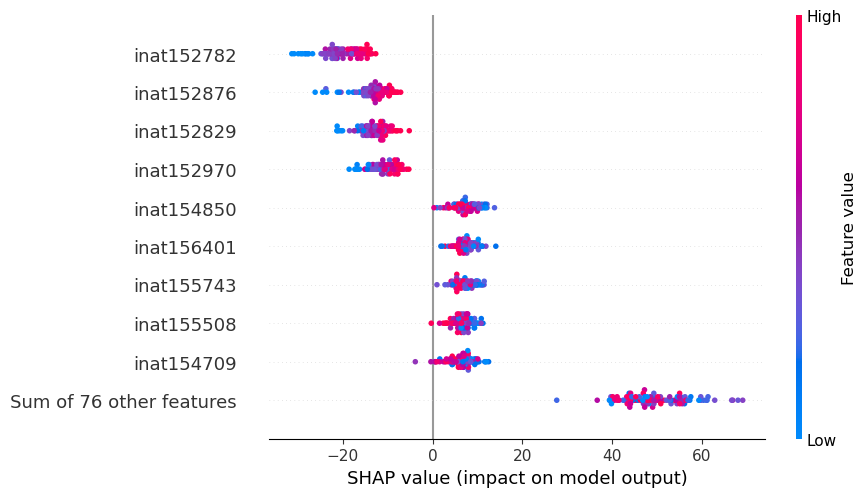

In [12]:
import shap

# Prepare your background and test datasets
background = X_train_std[:1000]
X_sample = X_test[:100]

# Define a prediction function
def predict_fn(data):
    return model.predict(data) 

# Create the SHAP explainer with permutation algorithm 
# This is a model agnostic explainer
explainer = shap.Explainer(predict_fn, background, algorithm='permutation')

# Compute SHAP values
shap_values = explainer(X_sample)

# Visualize the SHAP values for the first output
shap.plots.beeswarm(shap_values[:, :, 0])

In [ ]:
# DON'T RUN THIS AGAIN

# Save SHAP values for each channel
if not os.path.exists('shap_swarms'):
    os.makedirs('shap_swarms')
for i in range(84):
    shap.summary_plot(shap_values[:, :, i], sort=False, max_display=84, show=False)
    plt.title(f'SHAP Values for Channel {y.columns[i]}')
    #plt.savefig(f'shap_swarms/SHAP_Values_Channel_{y.columns[i]}.png')
    plt.close()

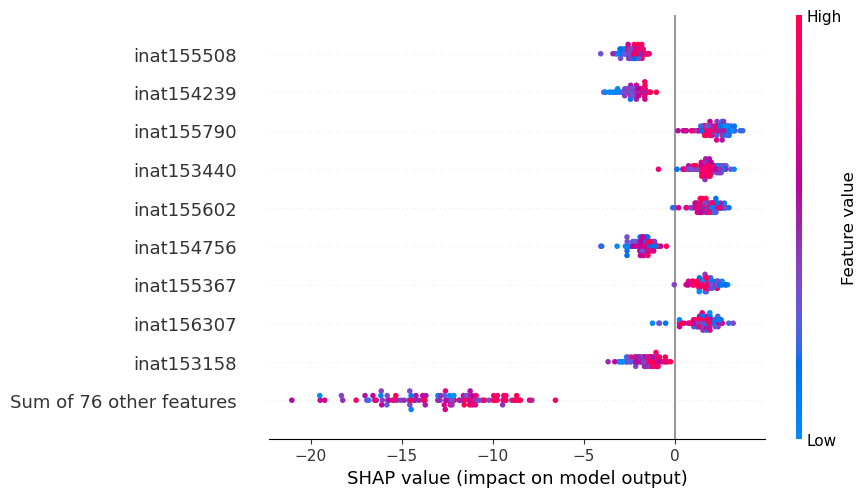

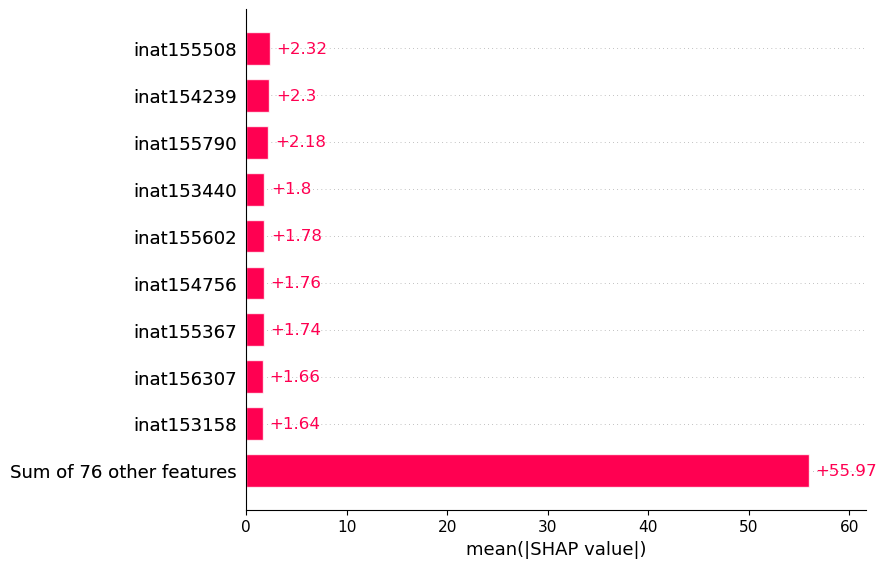

In [ ]:
# This is an "overall" SHAP value plot, averaging across all channels

mean_values = shap_values.values.mean(axis=2)  
mean_shap = shap.Explanation(values=mean_values,
                              data=shap_values.data, feature_names=shap_values.feature_names) 

shap.plots.beeswarm(mean_shap, max_display=10)
shap.plots.bar(mean_shap, max_display=10)


In [31]:
# Now we try classical regression methods to compare results
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Define a function to train and evaluate a regression model
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, mae, r2, training_time

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
}


# Use the best parameters found
best_one_every = 1  # Change this to the best one_every found
best_params = best_parameters[f'one_every_{best_one_every}']
print(f'Best parameters for one_every={best_one_every}: {best_params}')

X_temp, freq_chan = extract_features(raw_data, one_every=best_one_every)
X = X_temp[X_temp.columns[1:2+freq_chan]]
y = X_temp[X_temp.columns[-84:]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)


# Train and evaluate each model
results = {}
for model_name, model in models.items():
    mse, mae, r2, training_time = train_and_evaluate(model, X_train_std, y_train, X_test_std, y_test)
    results[model_name] = {
        'MSE': mse,
        'MAE': mae,
        'R2': r2,
        'Training Time': training_time
    }




Best parameters for one_every=1: {'activation': 'relu', 'neurons': 128, 'layers': 2, 'mse': 0.04199244976043701, 'mae': 0.14574085175991058, 'r2': 0.9902734756469727, 'training_time': 48.48757553100586}


In [32]:
results

{'Linear Regression': {'MSE': 0.032971485489650745,
  'MAE': 0.12428895616131226,
  'R2': 0.9925124834688498,
  'Training Time': 0.036298274993896484},
 'Random Forest': {'MSE': 0.2338196640622497,
  'MAE': 0.2711181178210678,
  'R2': 0.9430002728908873,
  'Training Time': 290.96818709373474}}

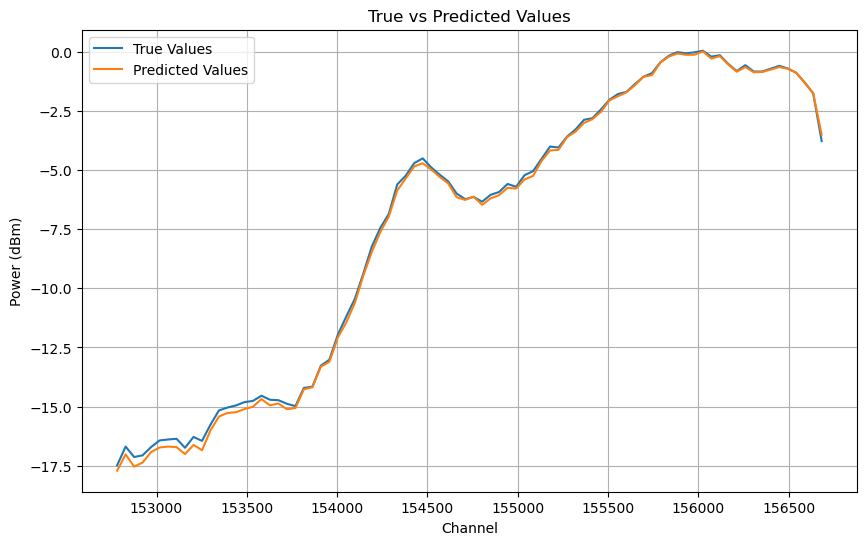

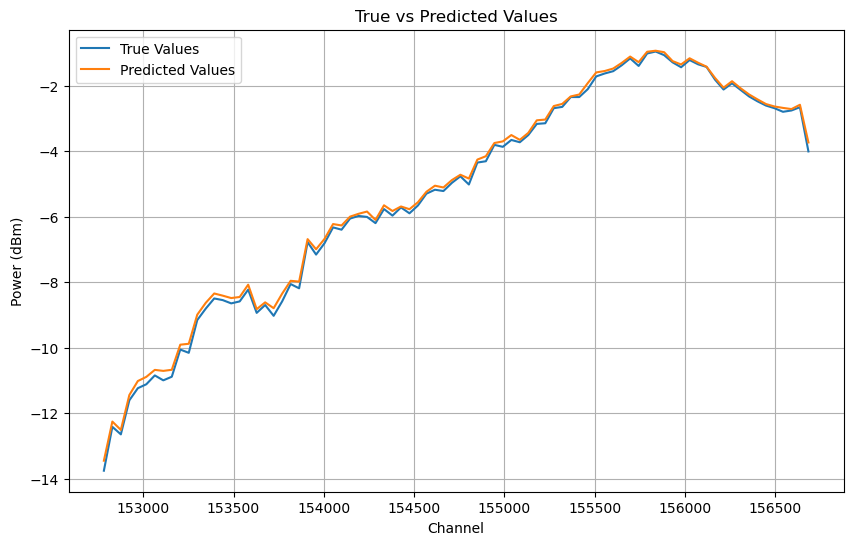

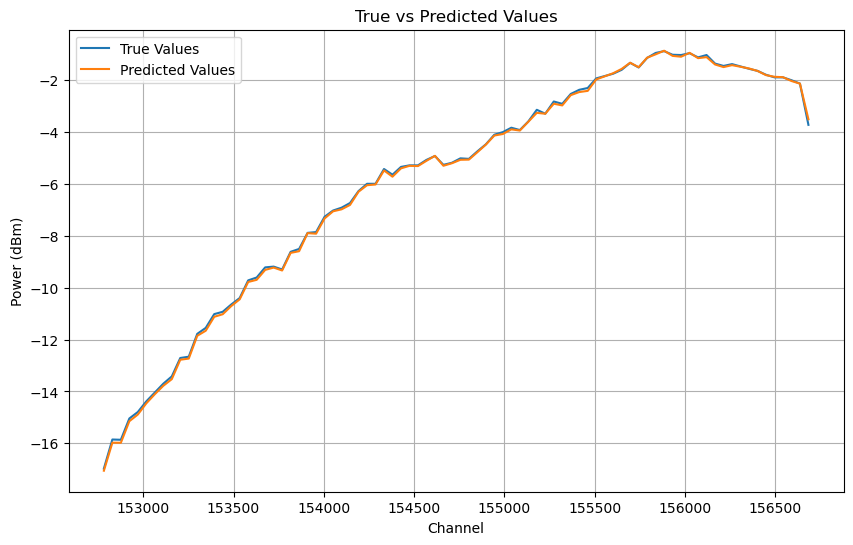

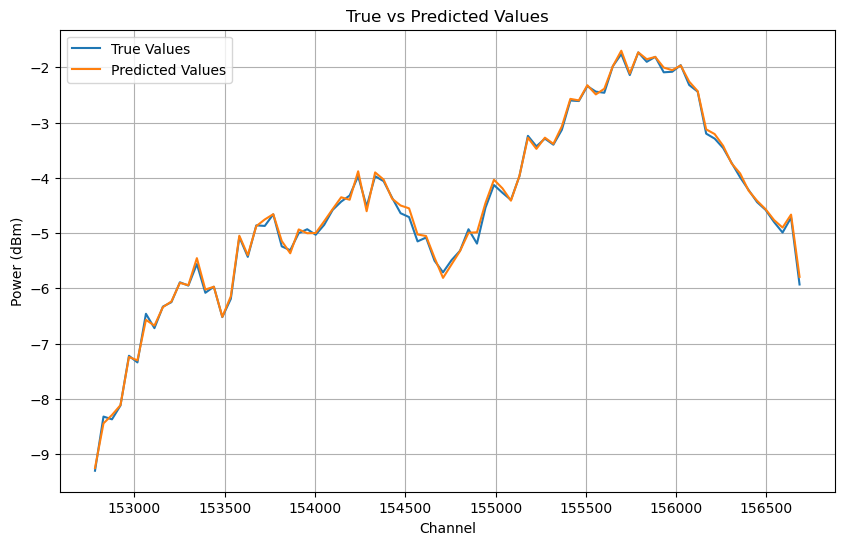

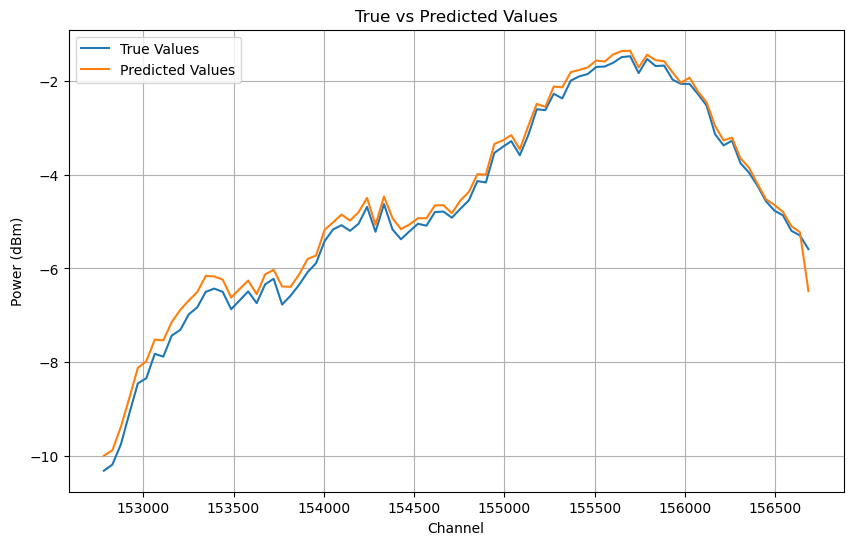

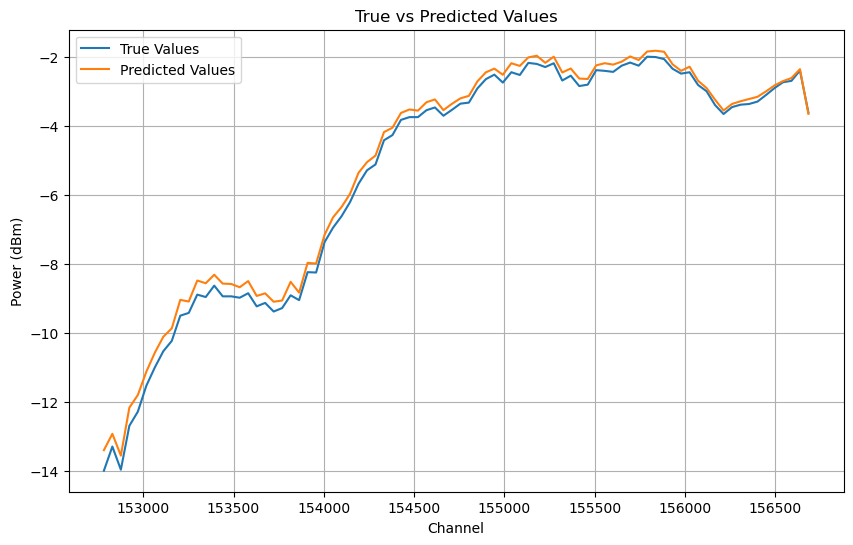

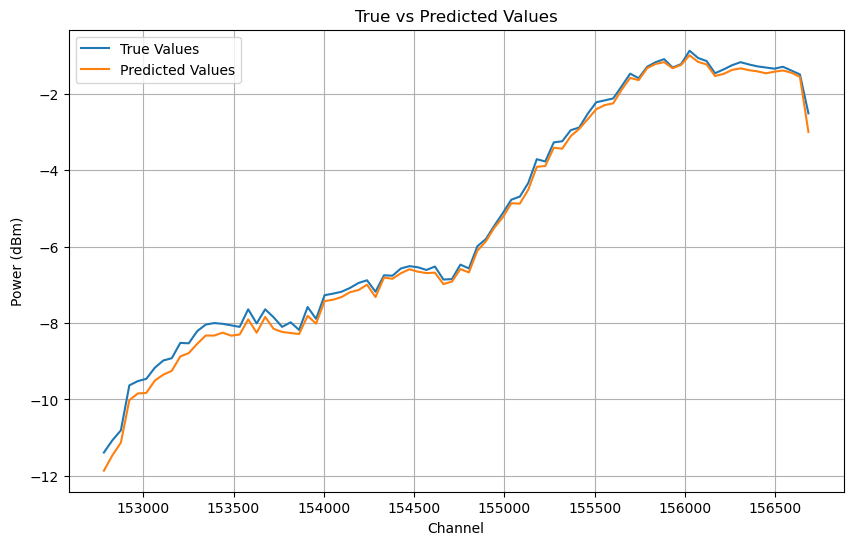

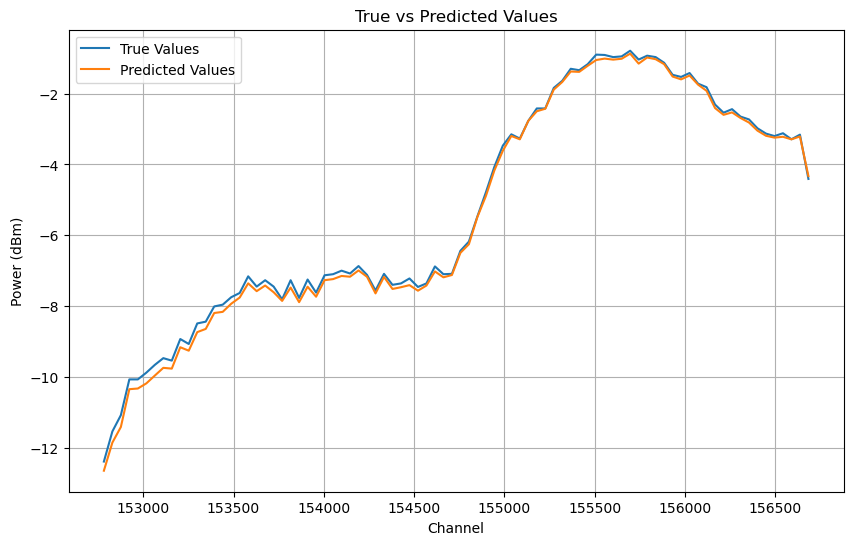

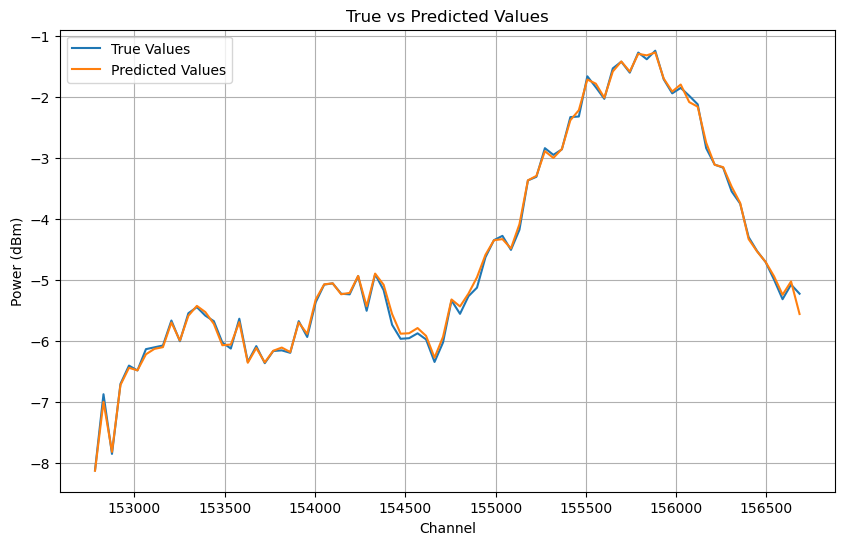

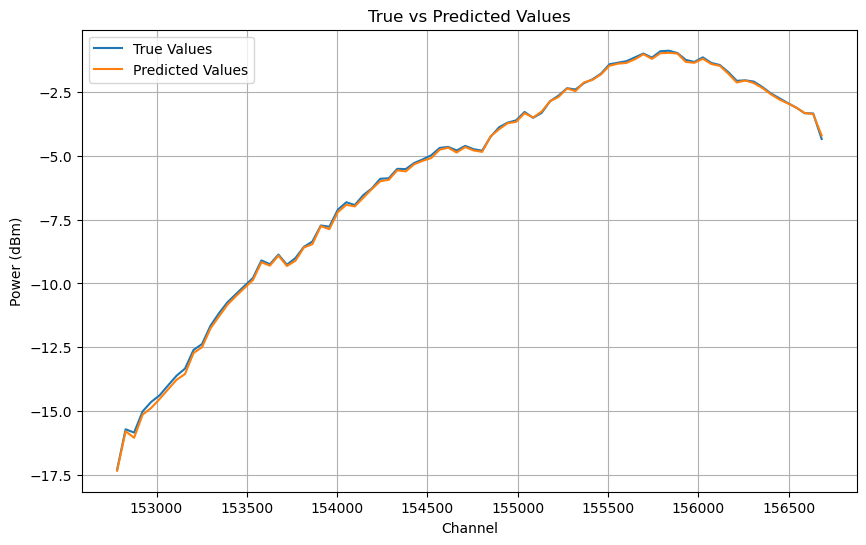

In [33]:
min_freq = 152782
max_freq = 156683

freqs = np.linspace(min_freq, max_freq, 84)

y_pred = models['Linear Regression'].predict(X_test_std)
# Convert predictions to DataFrame for easier plotting
y_pred = pd.DataFrame(y_pred, columns=y_test.columns)
for idx in range(10): 
    #Plot
    plt.figure(figsize=(10, 6))
    plt.plot(freqs, y_test.iloc[idx], label='True Values')
    plt.plot(freqs, y_pred.iloc[idx], label='Predicted Values')
    plt.title('True vs Predicted Values')
    plt.xlabel('Channel')
    plt.ylabel('Power (dBm)')
    plt.legend()
    plt.grid()
    plt.show()

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


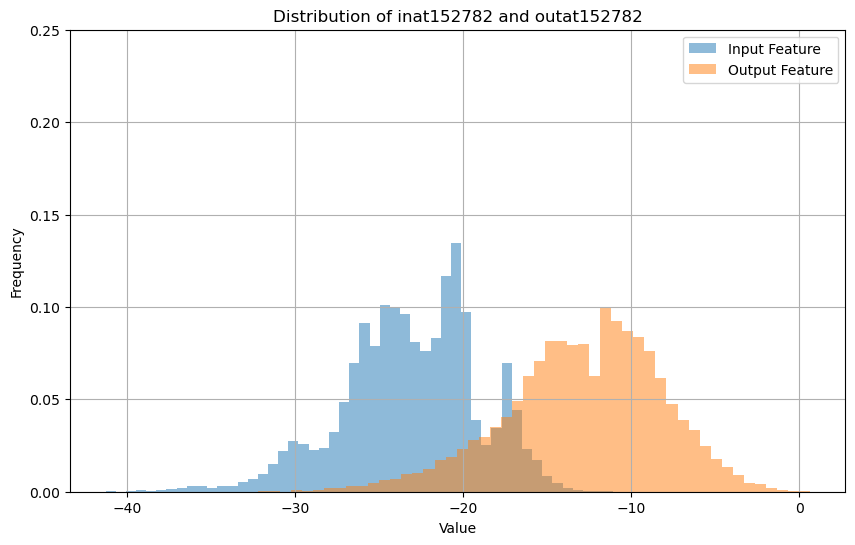

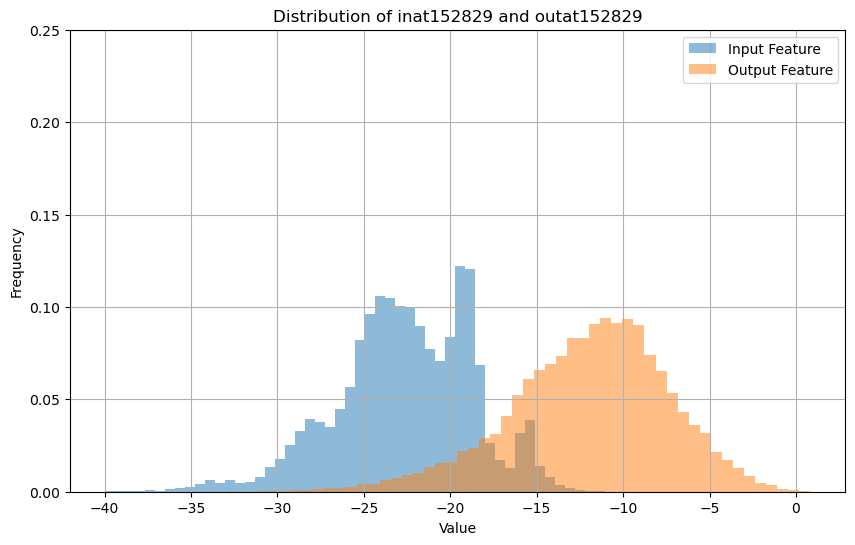

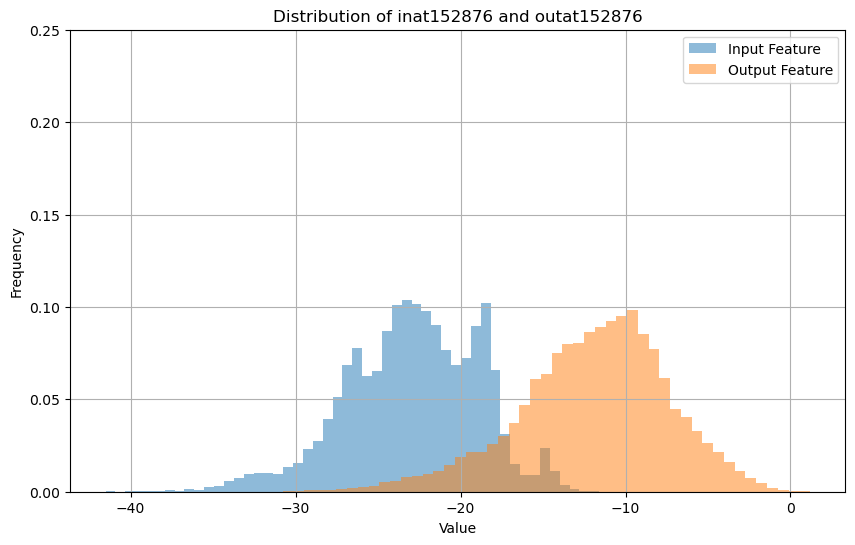

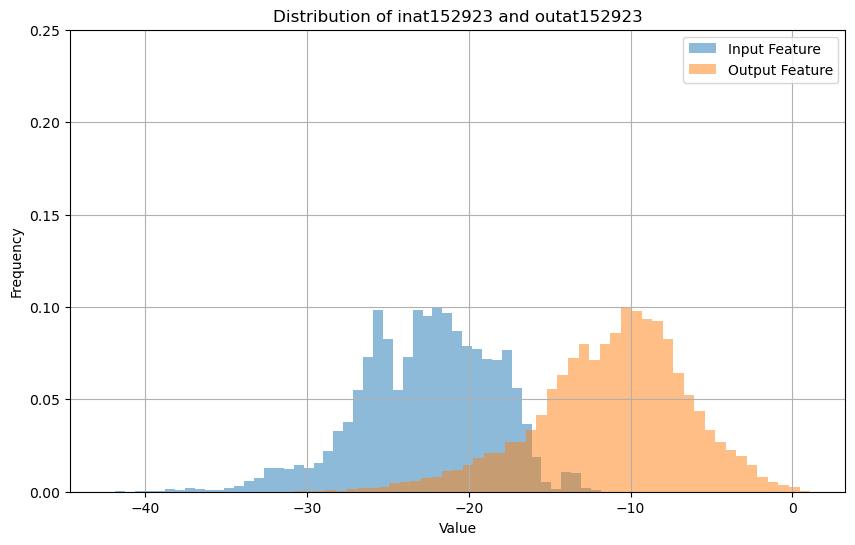

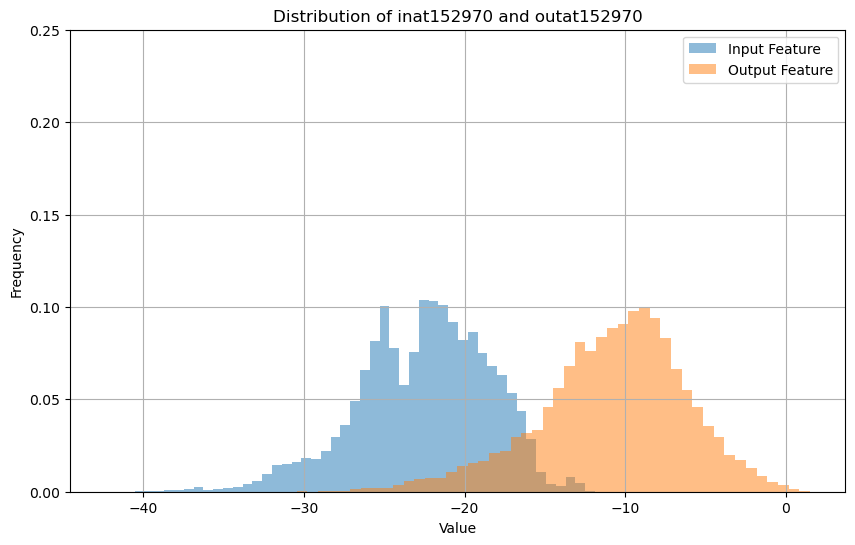

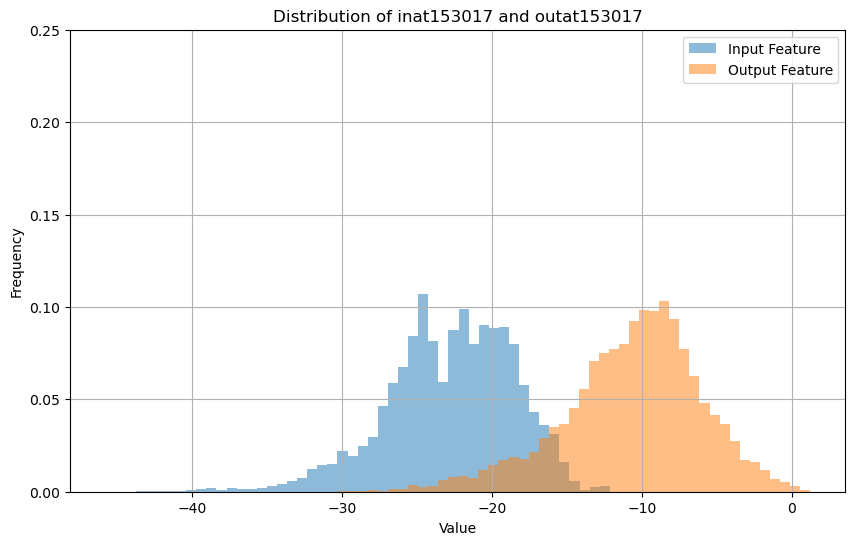

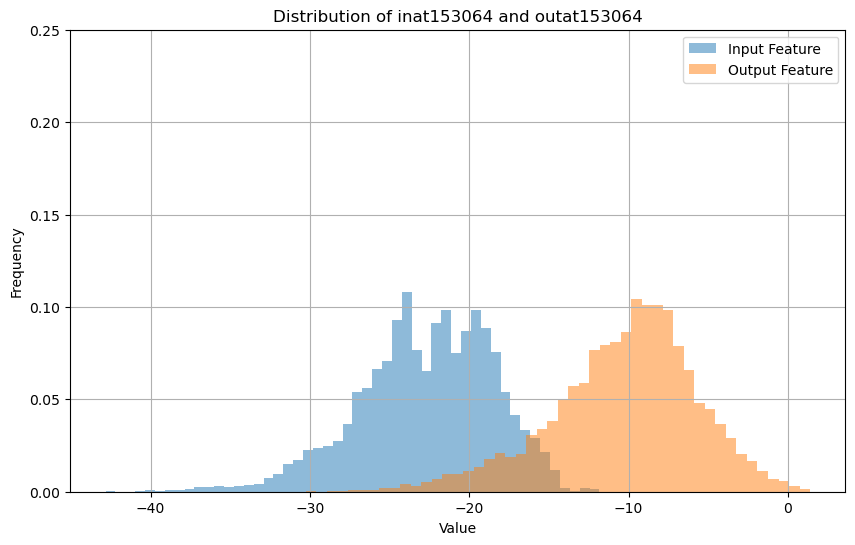

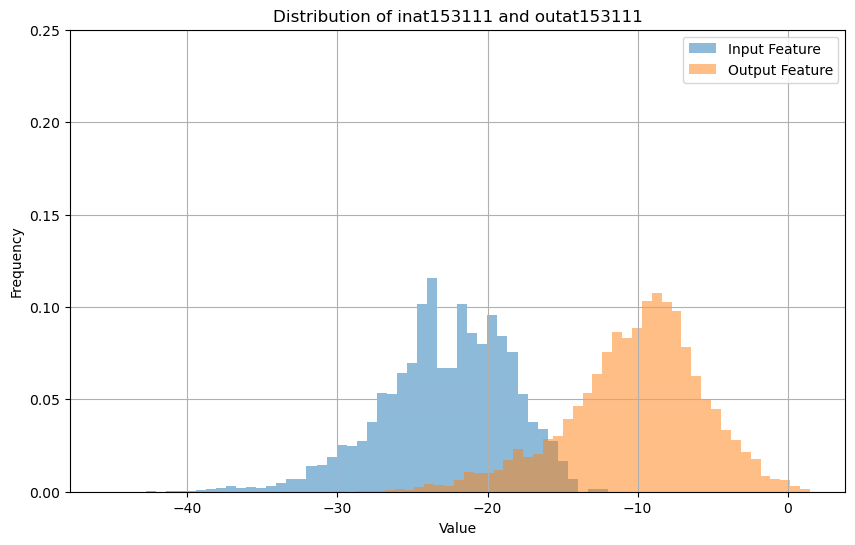

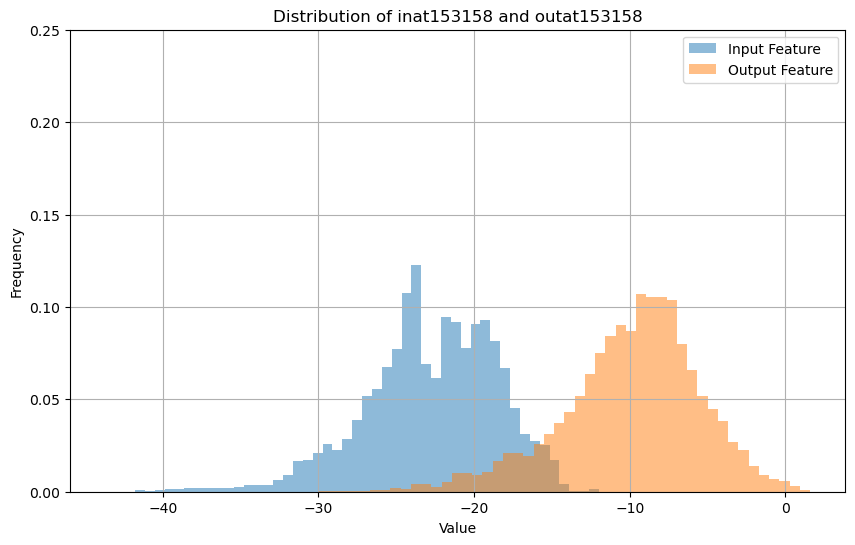

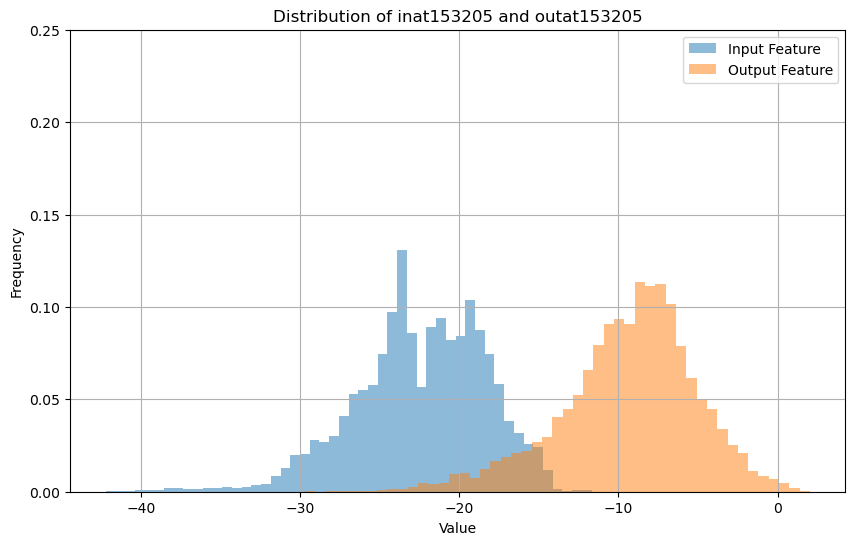

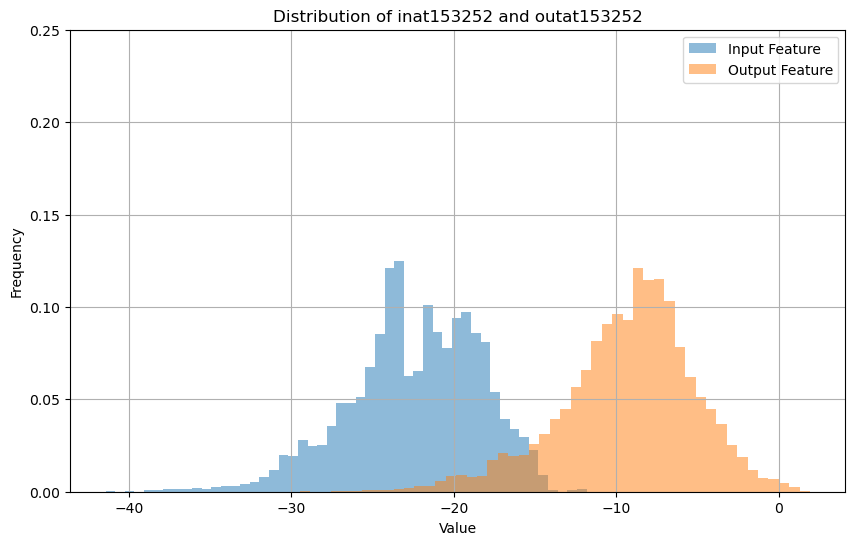

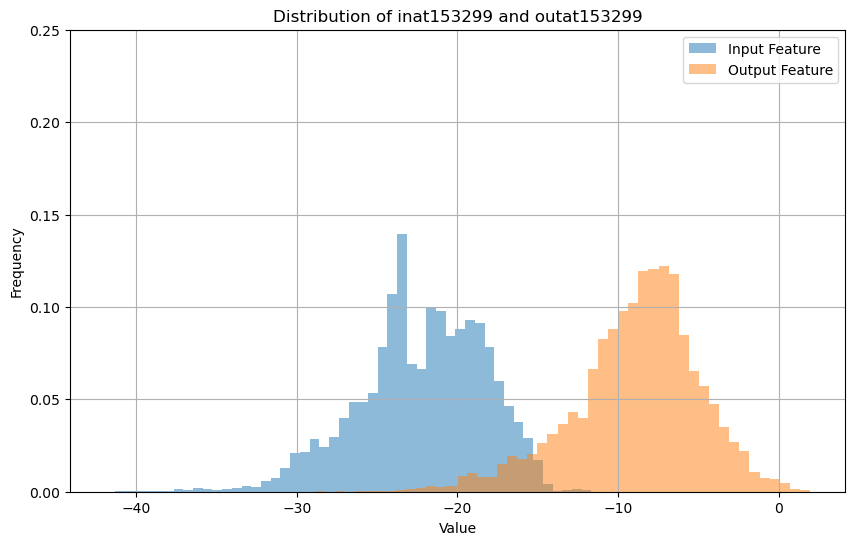

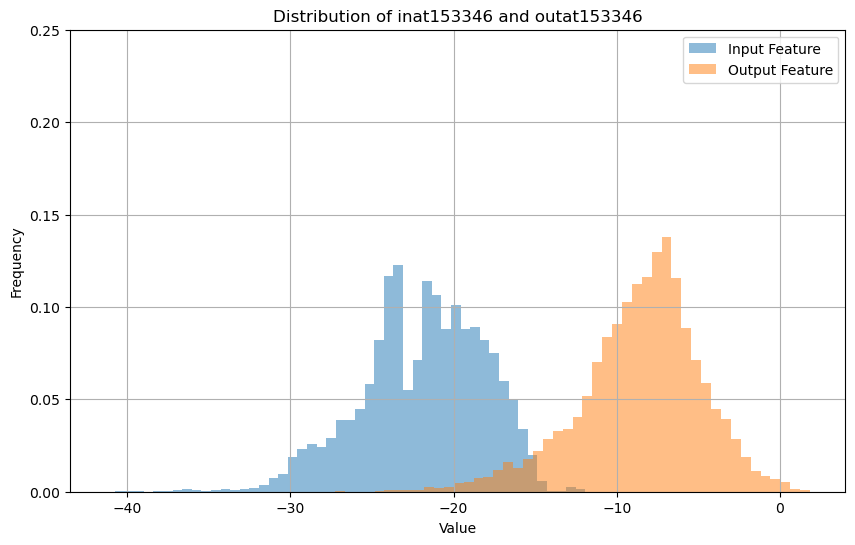

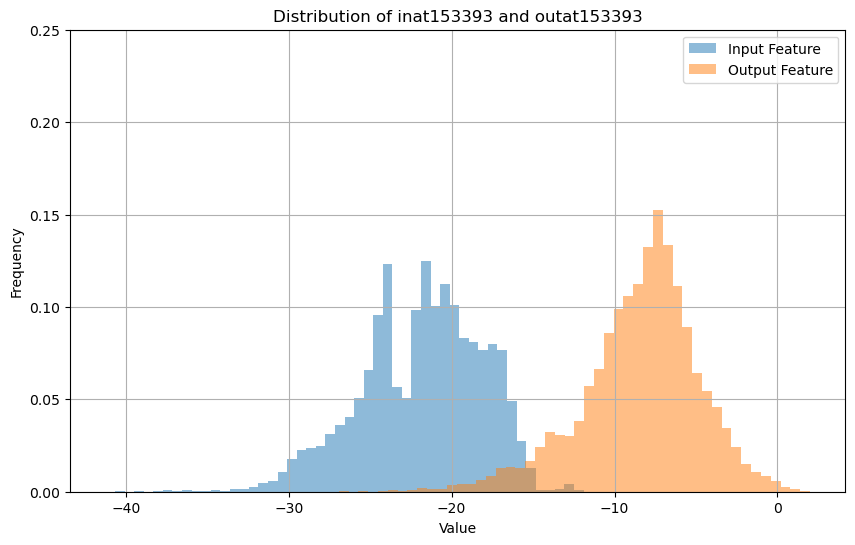

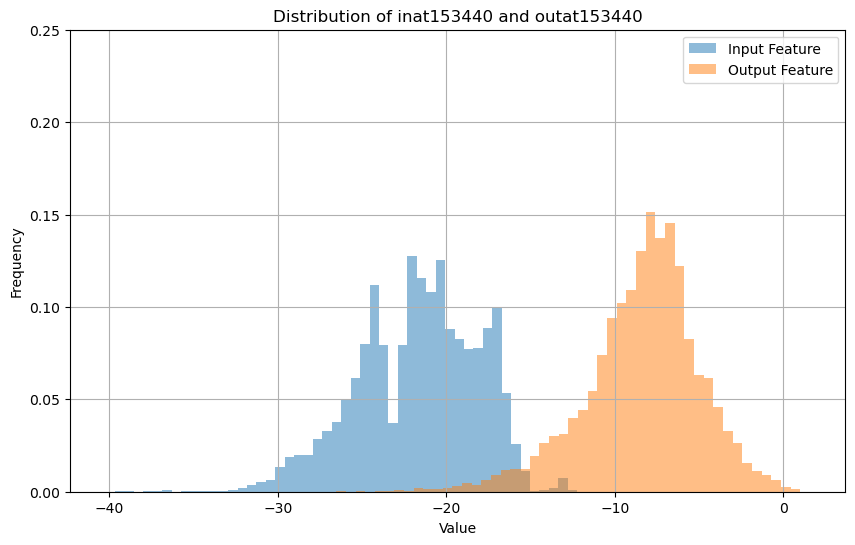

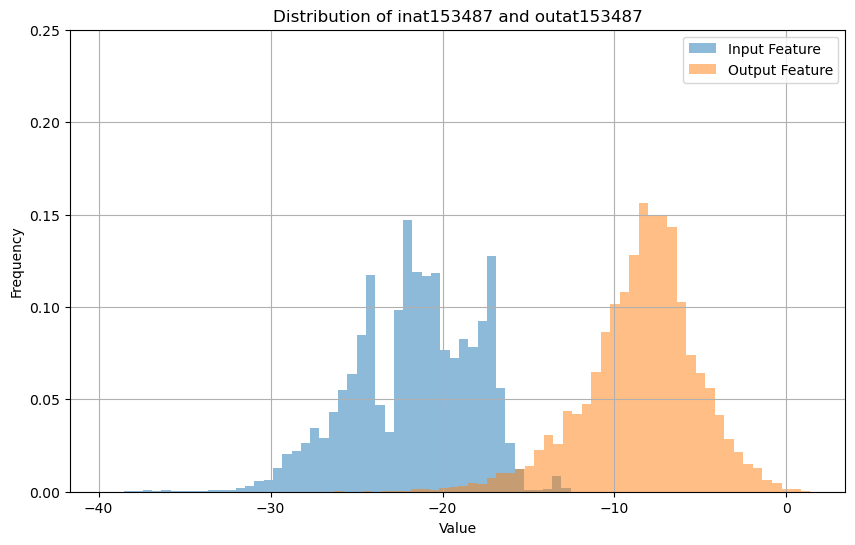

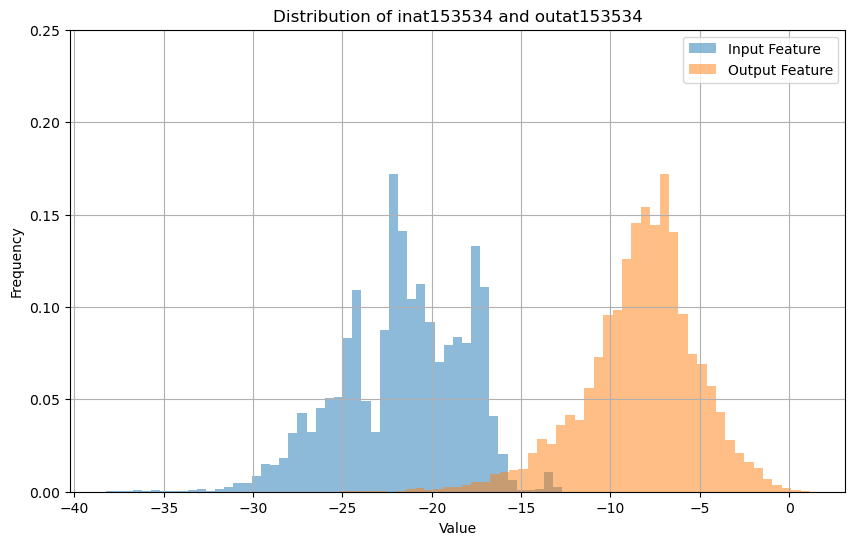

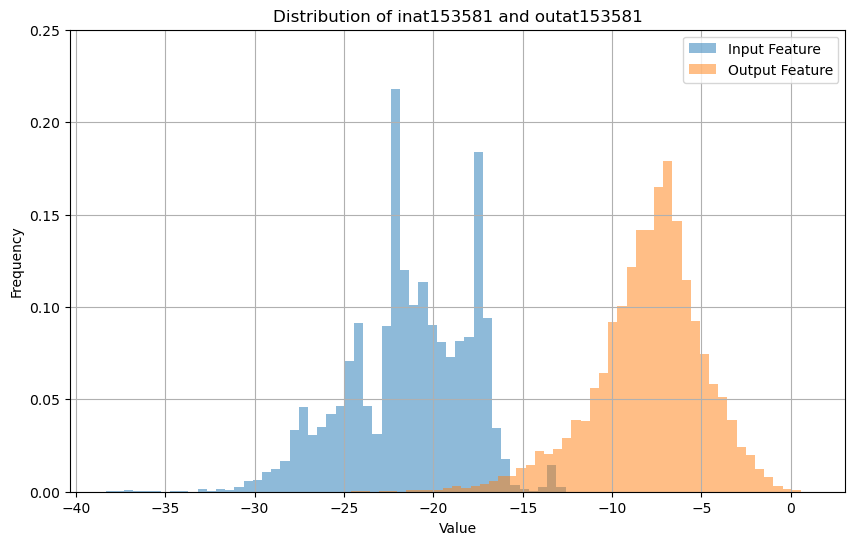

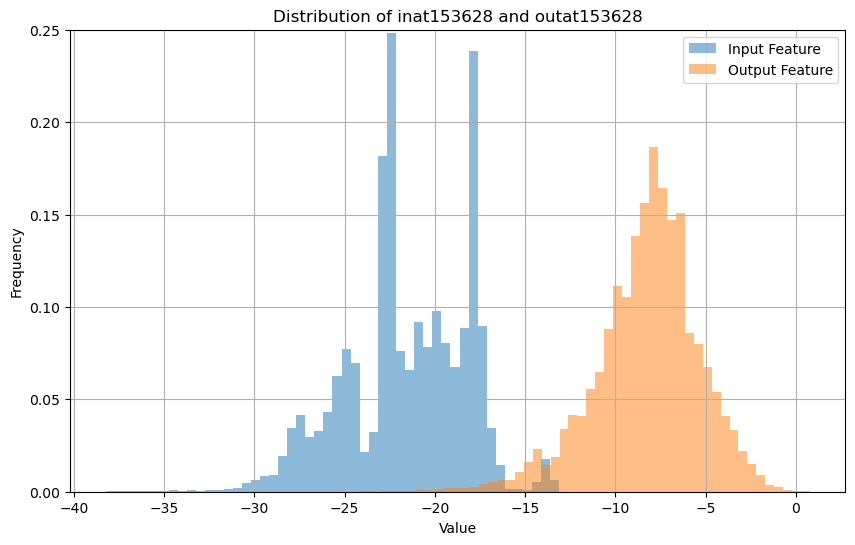

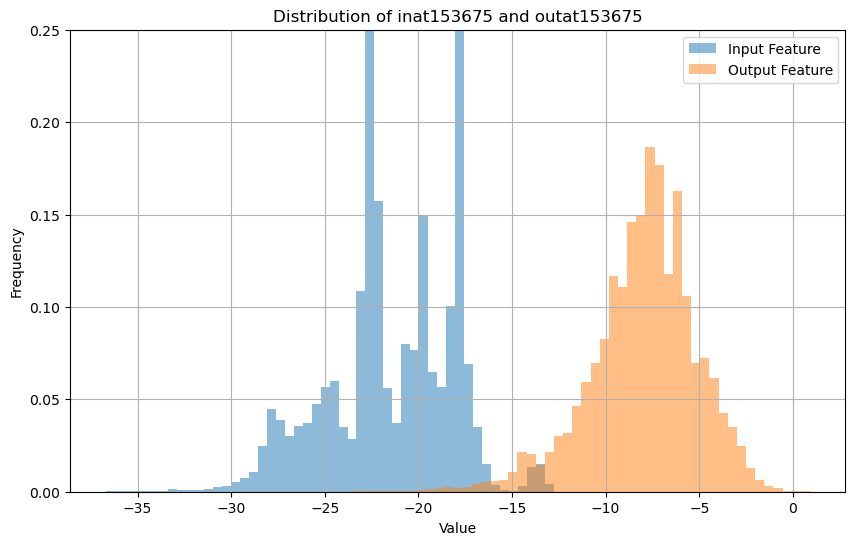

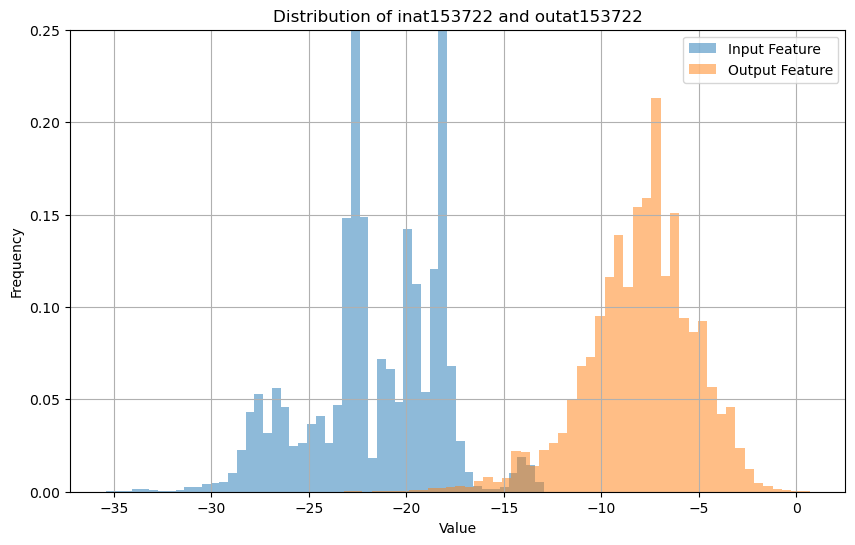

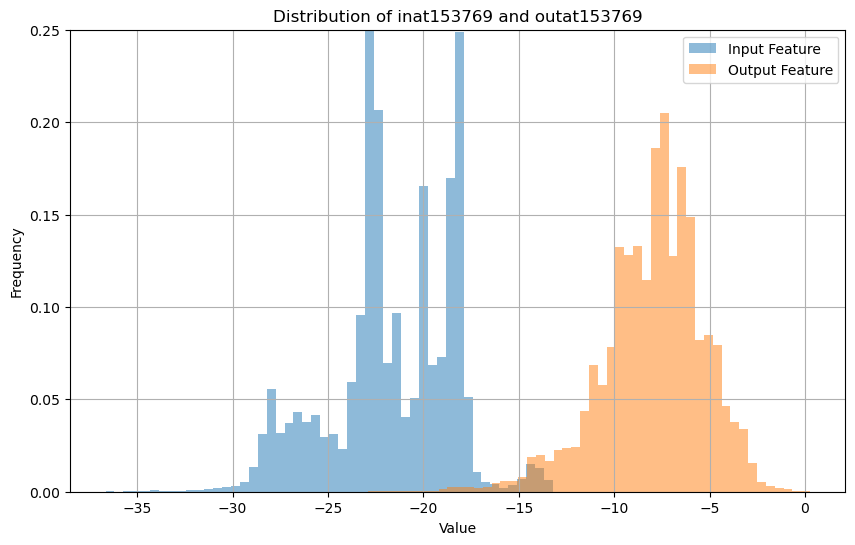

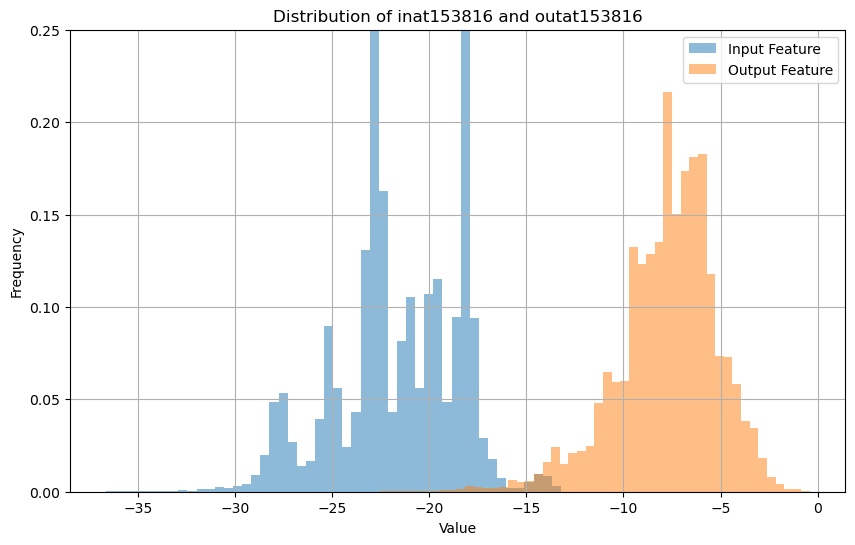

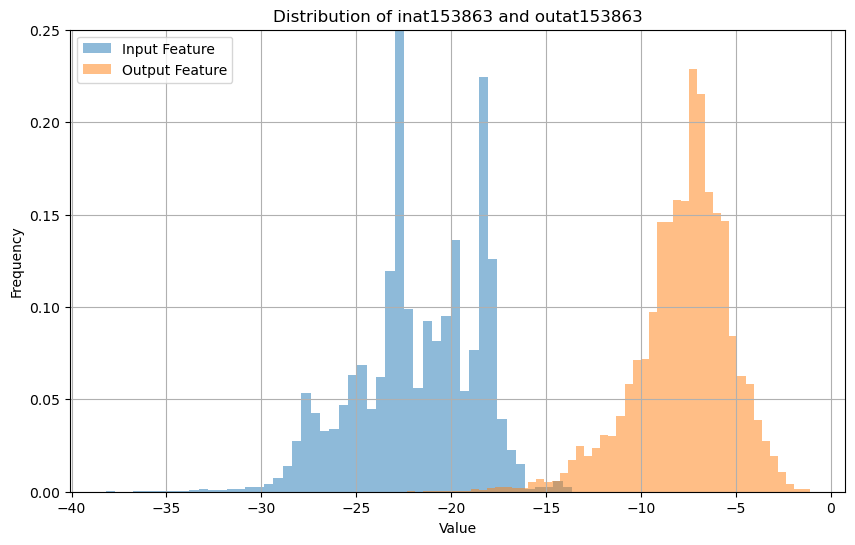

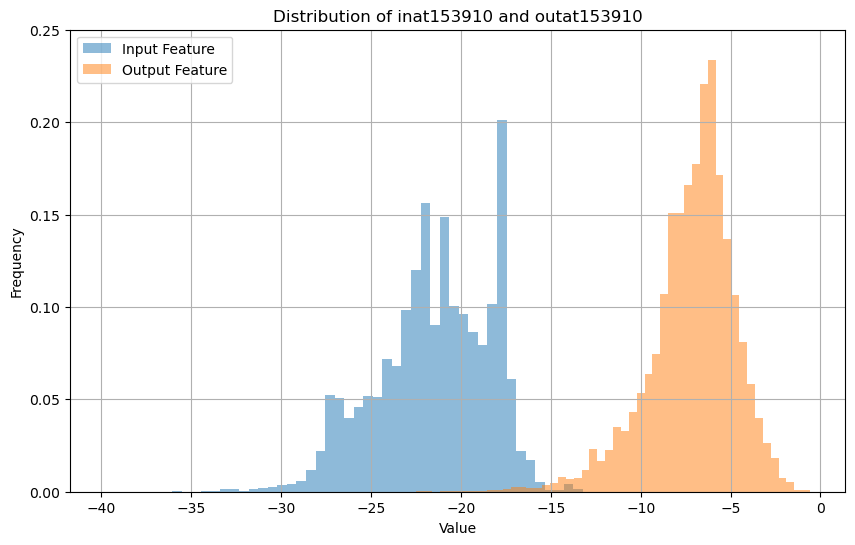

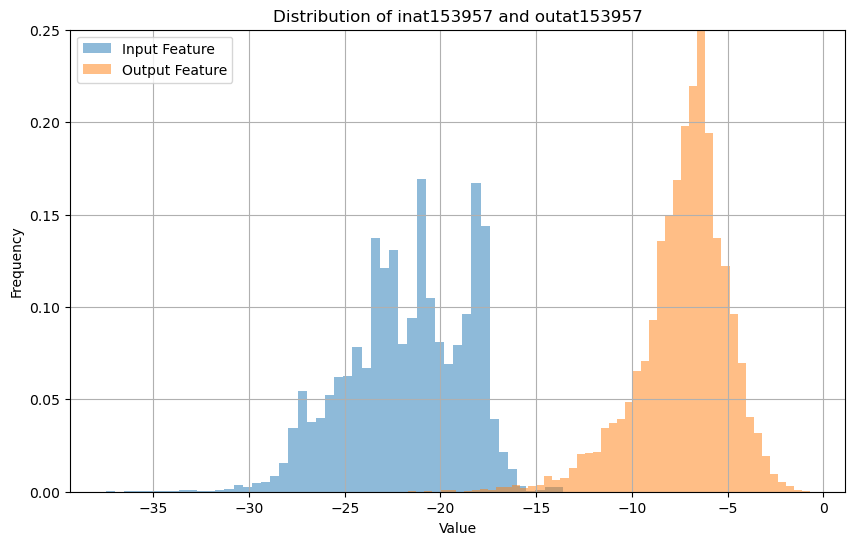

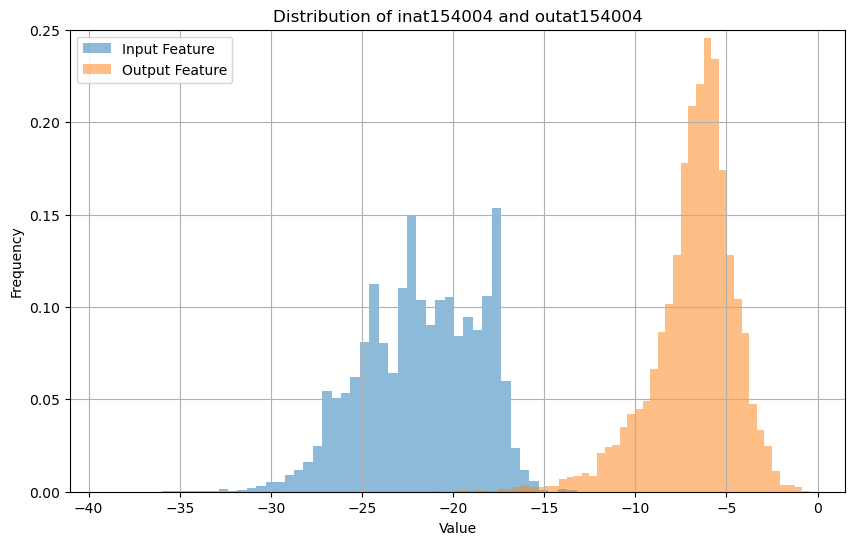

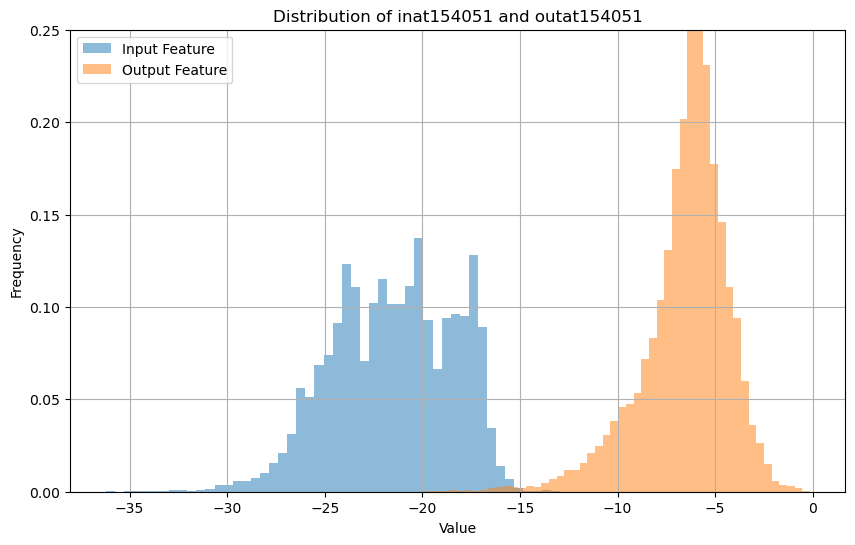

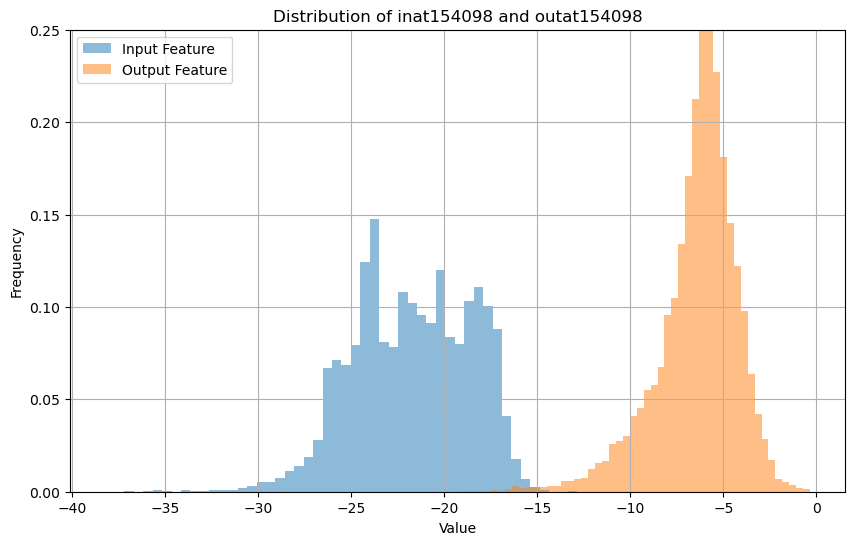

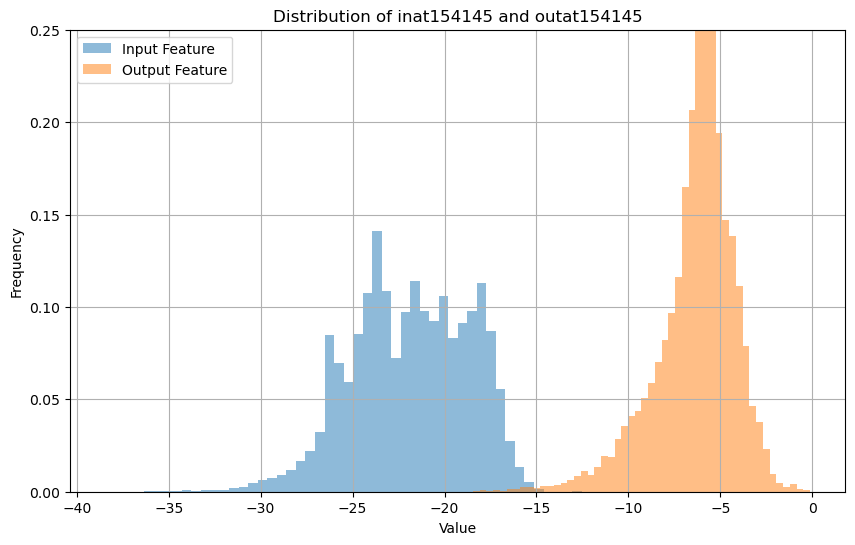

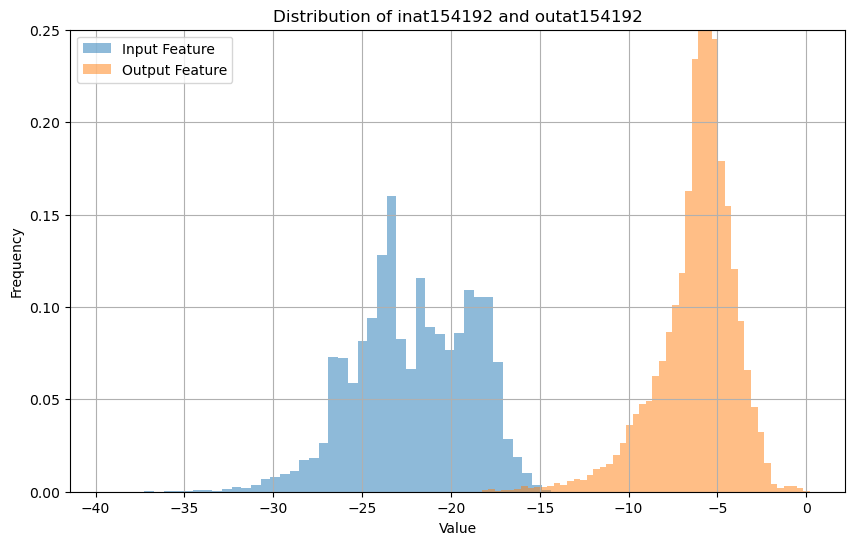

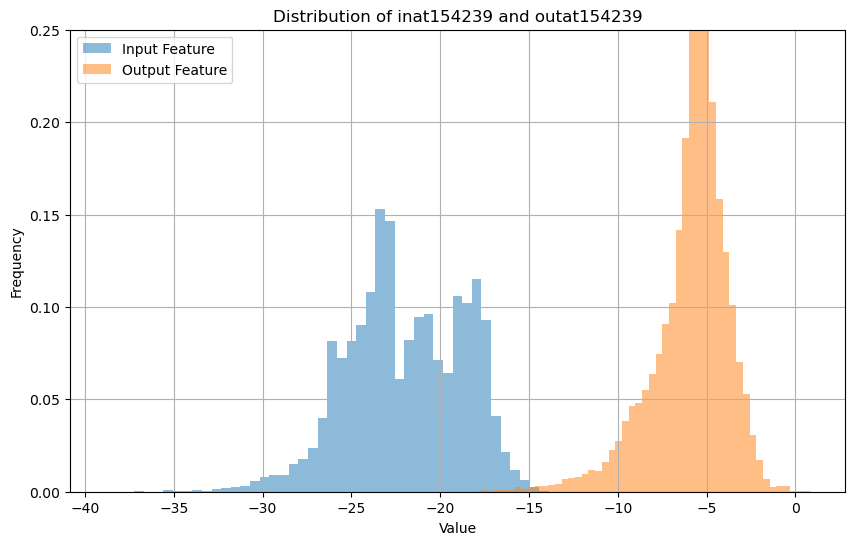

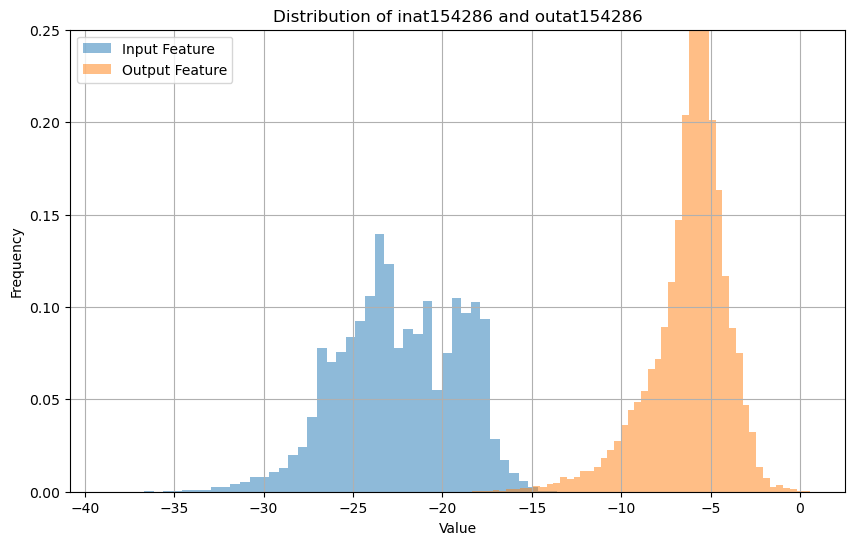

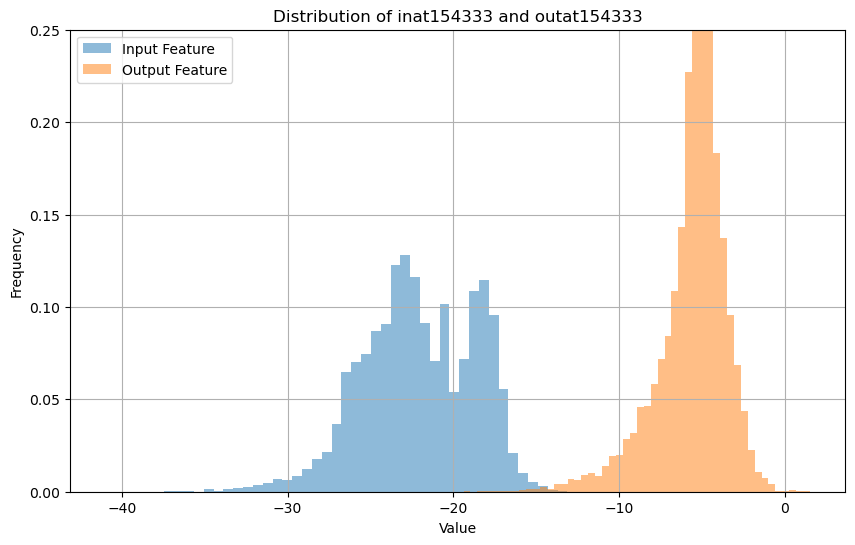

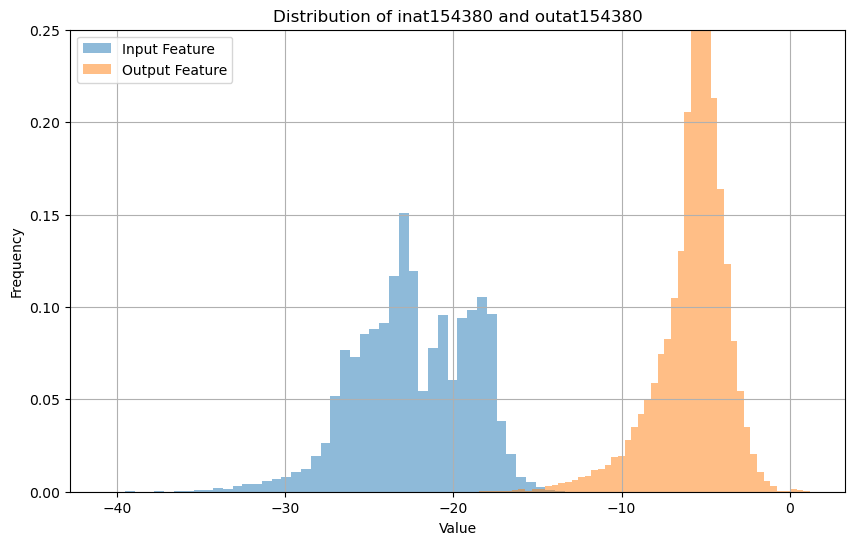

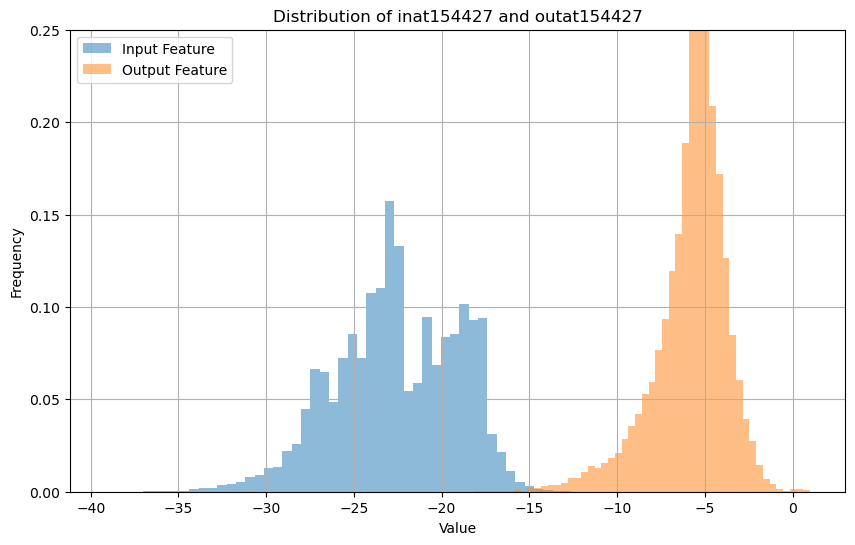

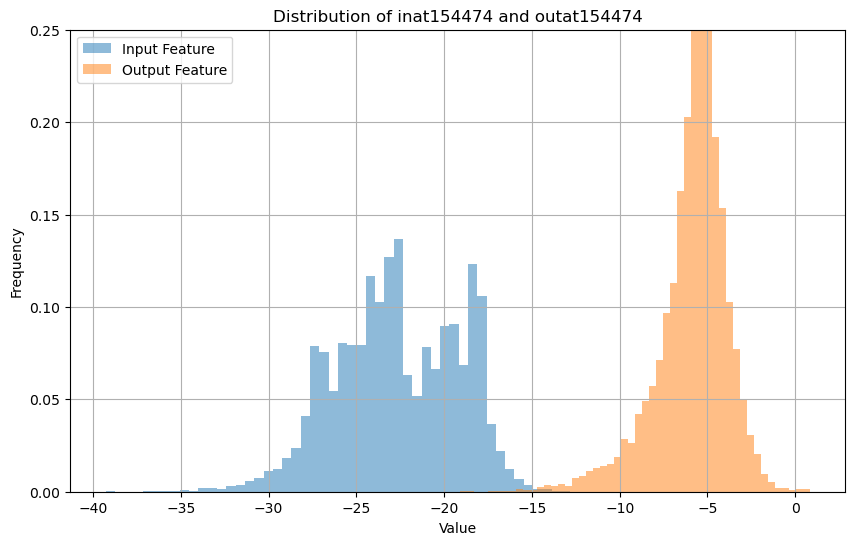

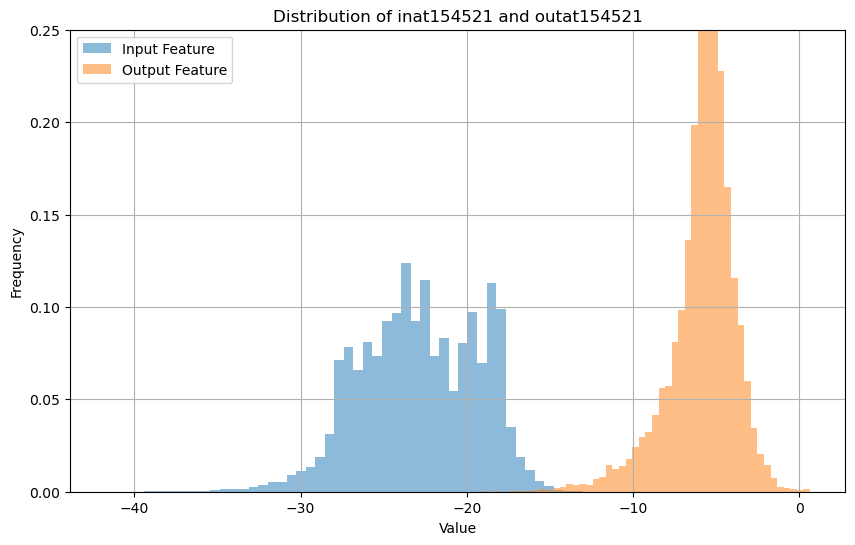

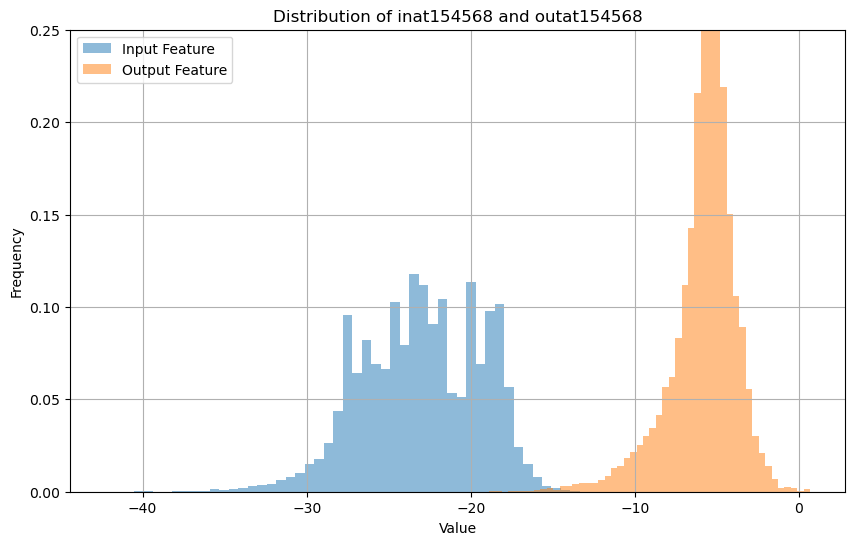

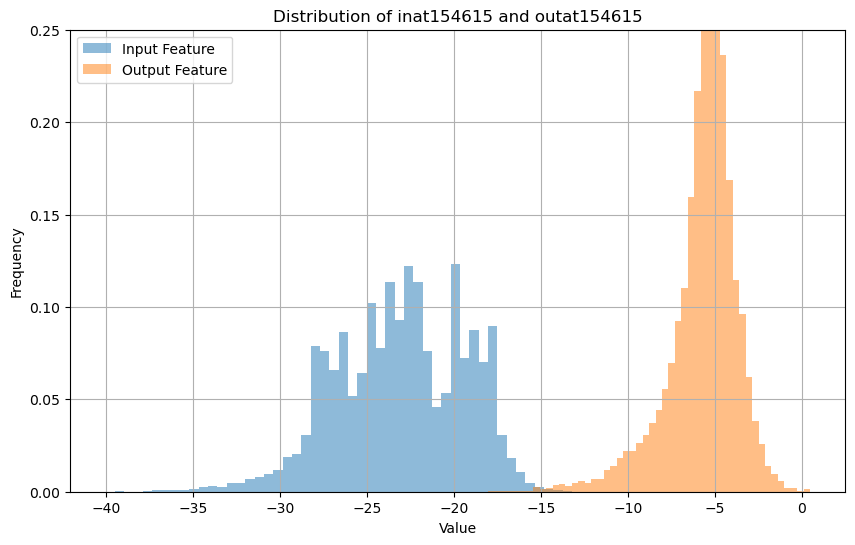

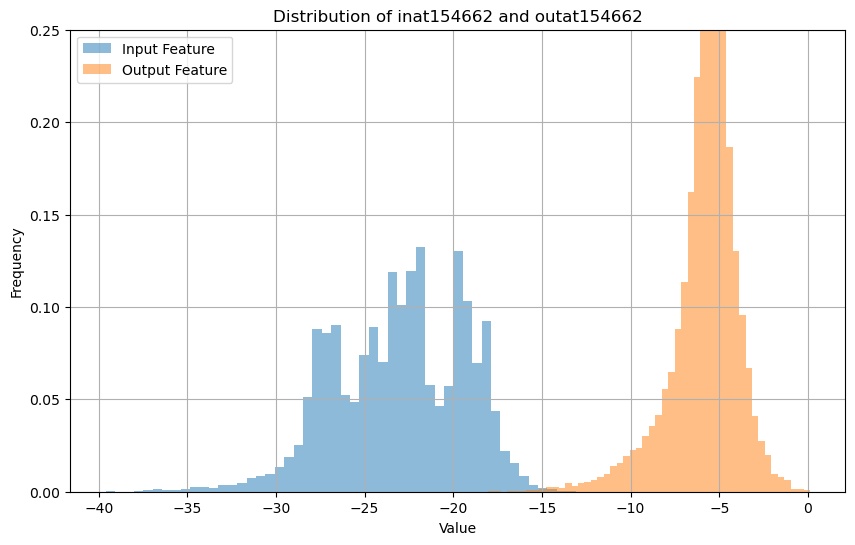

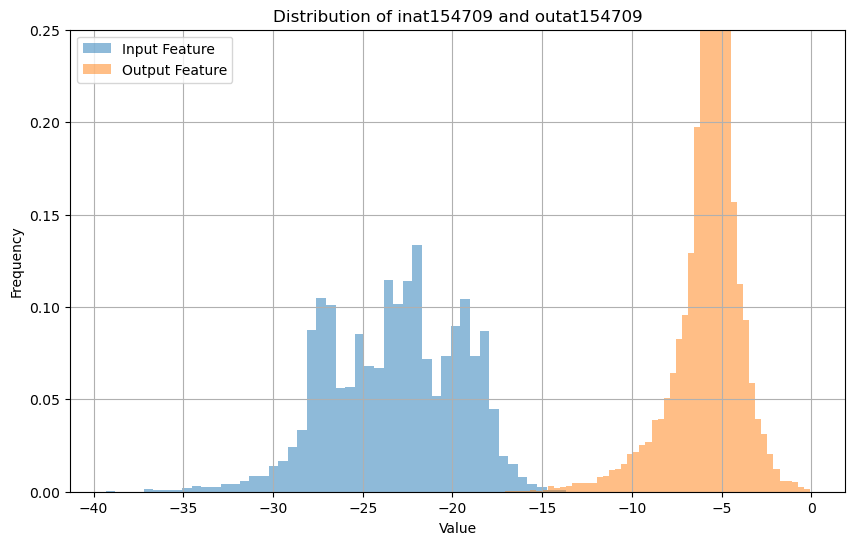

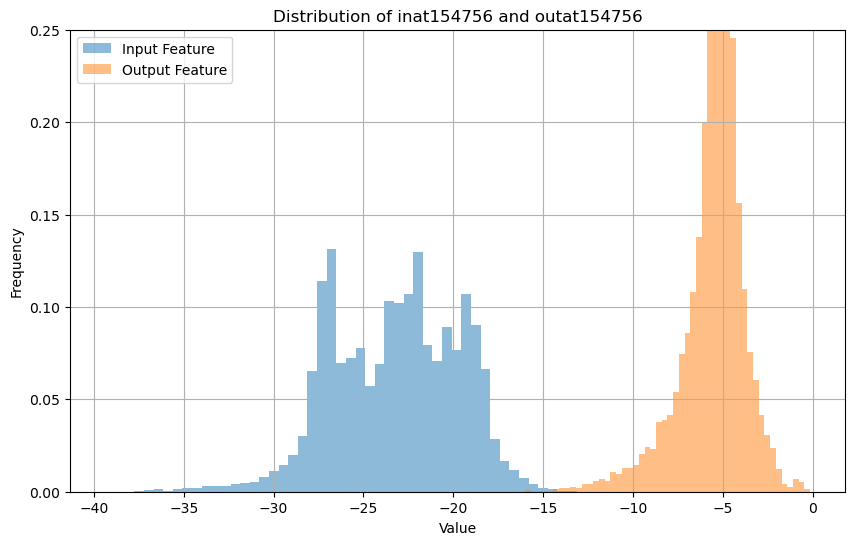

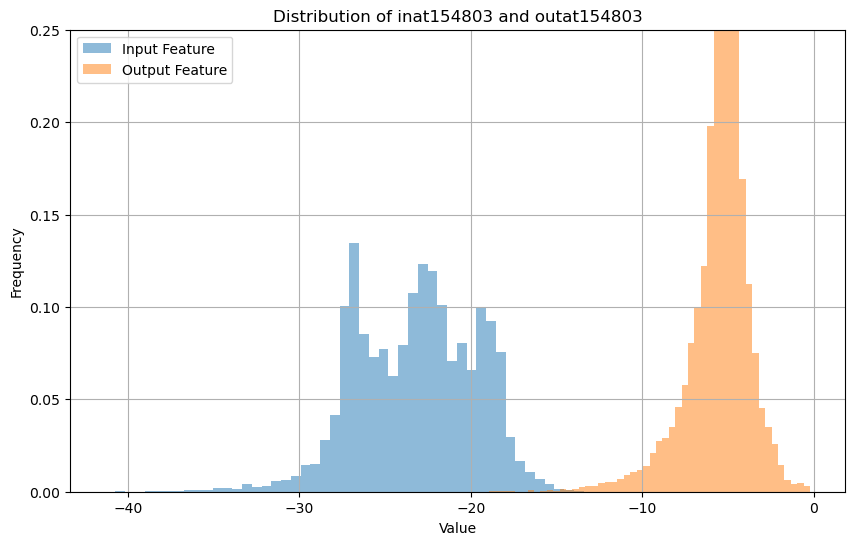

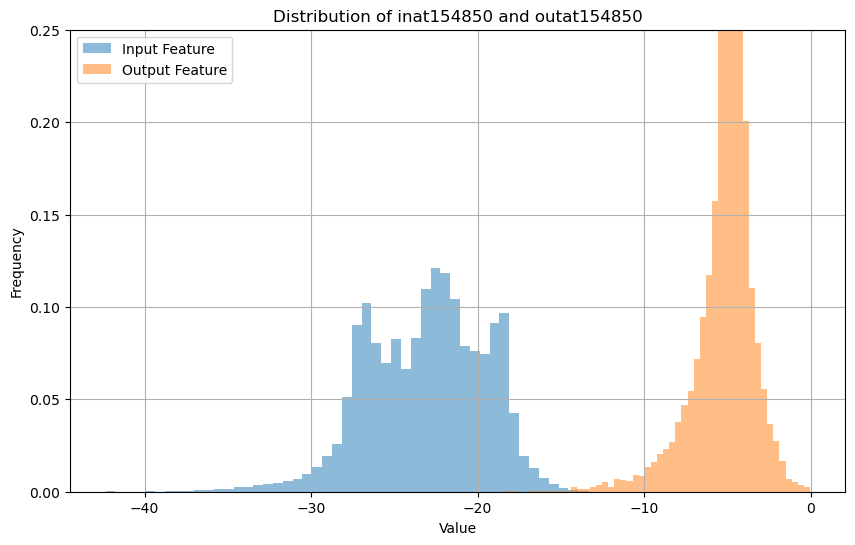

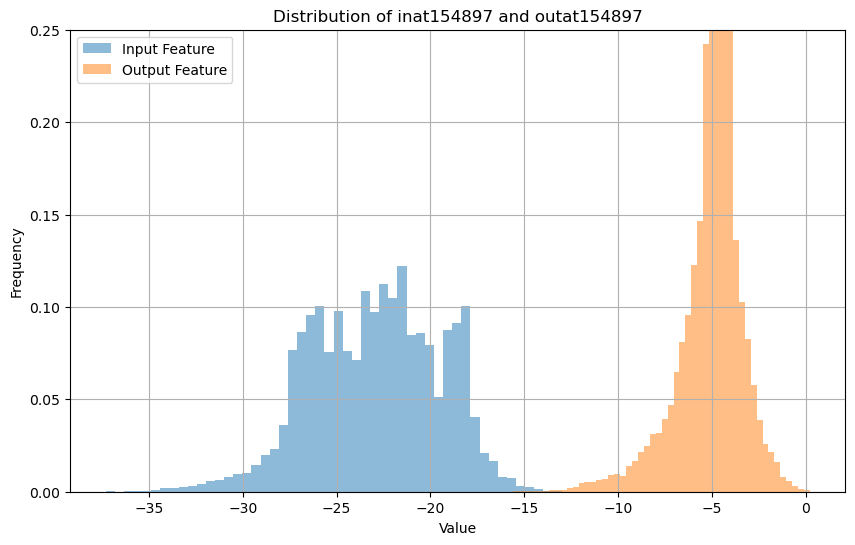

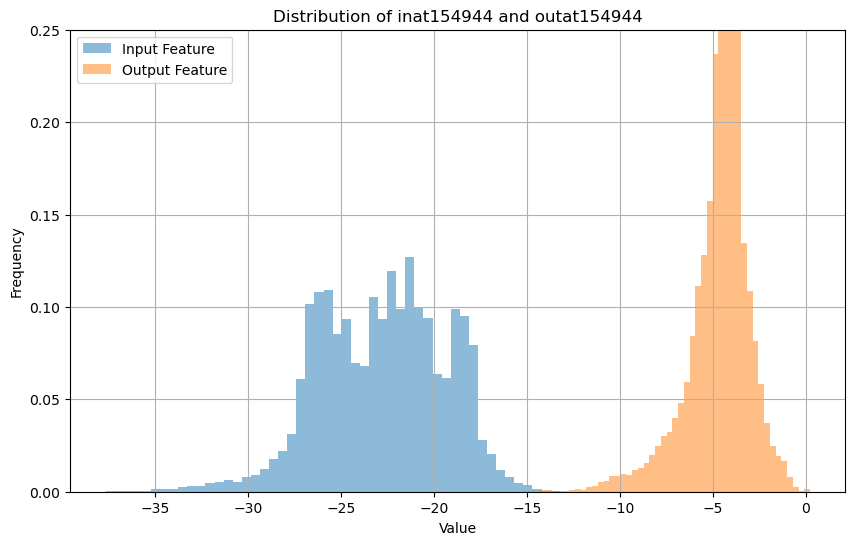

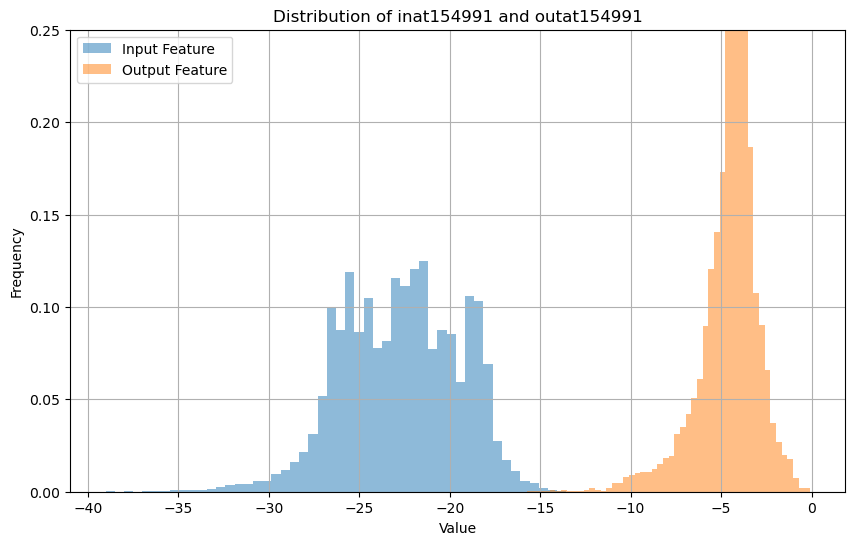

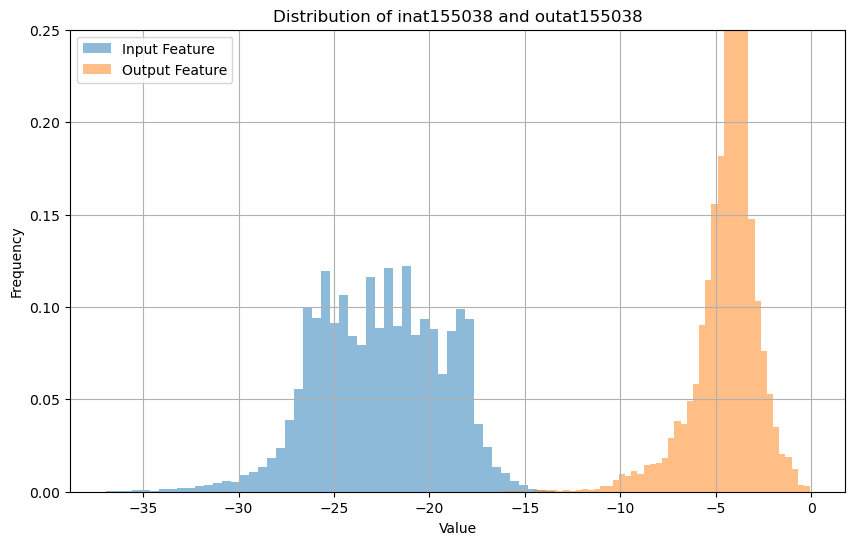

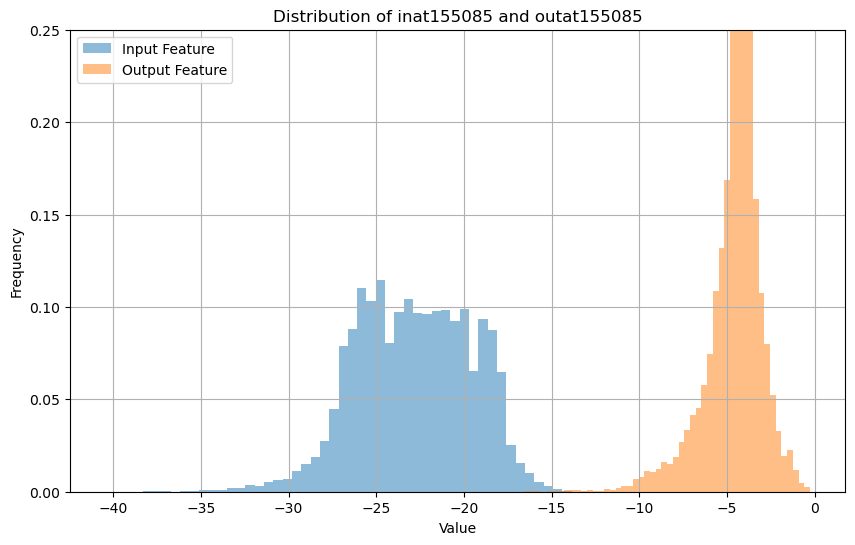

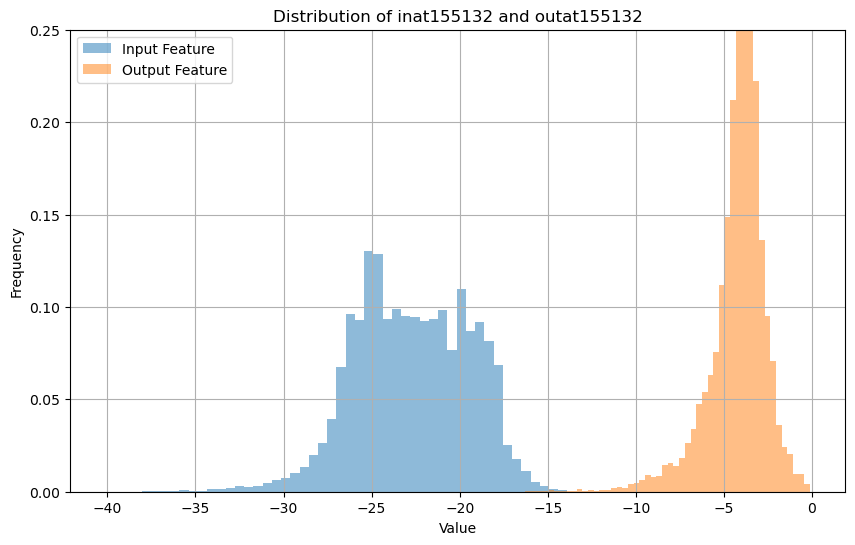

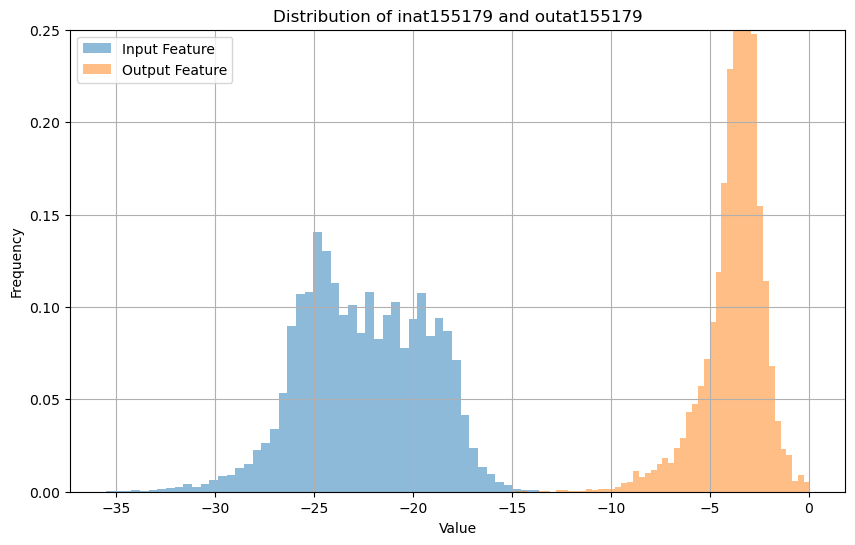

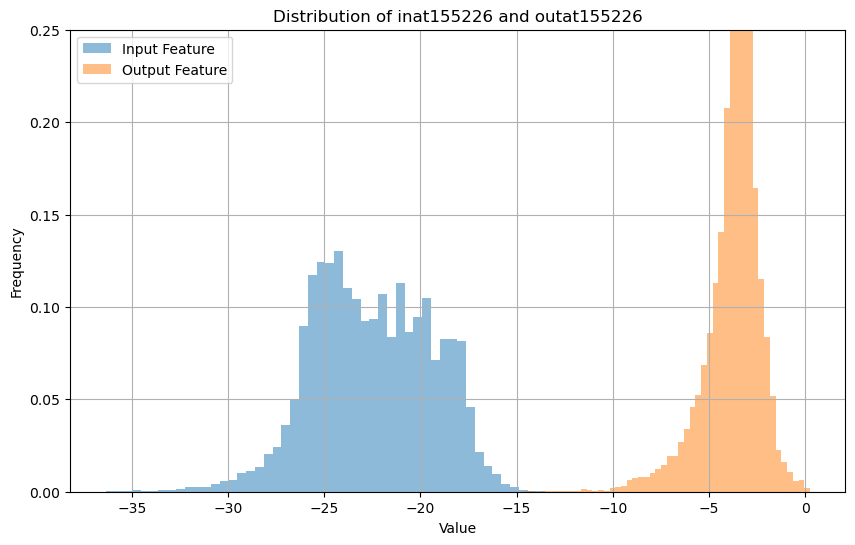

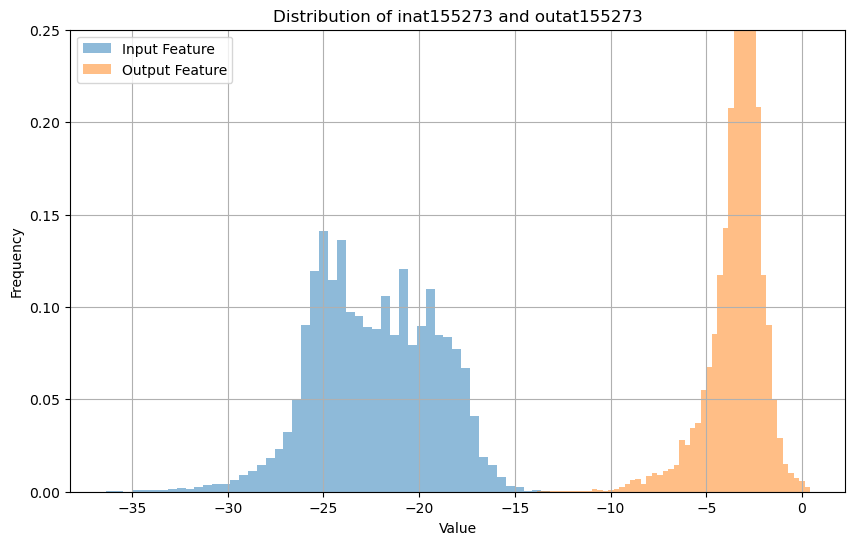

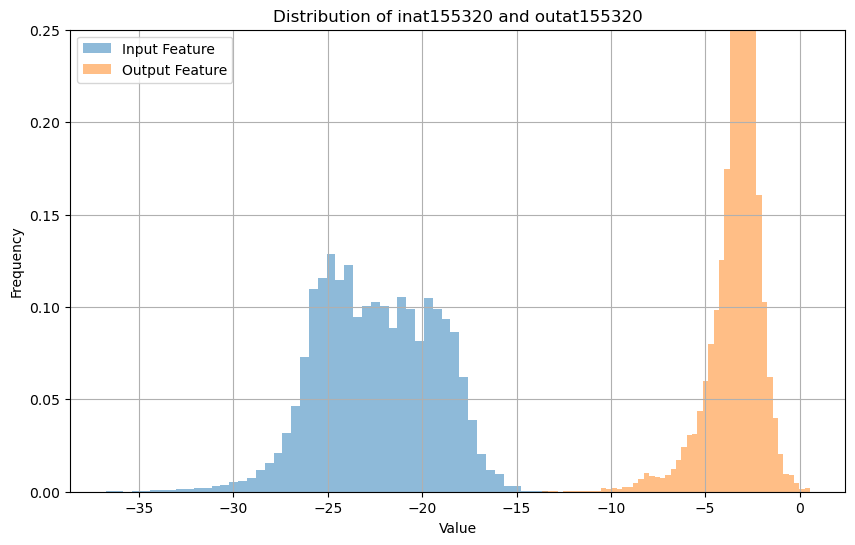

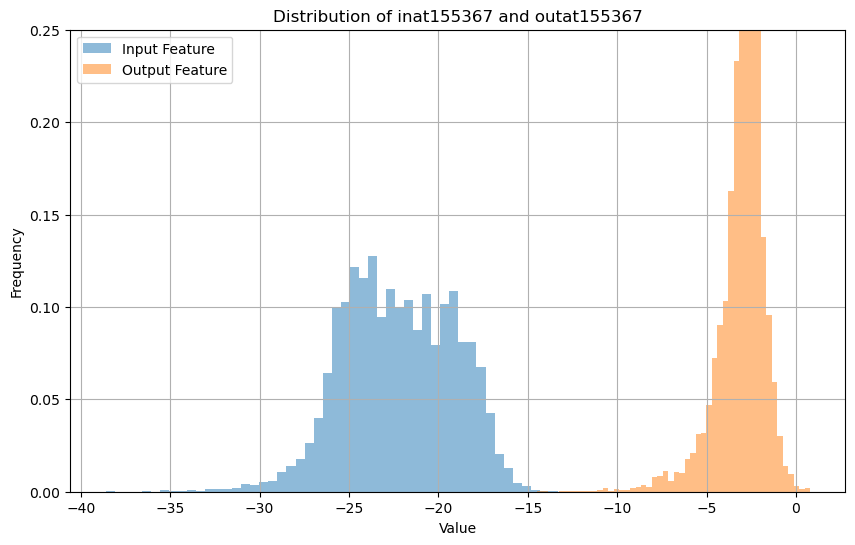

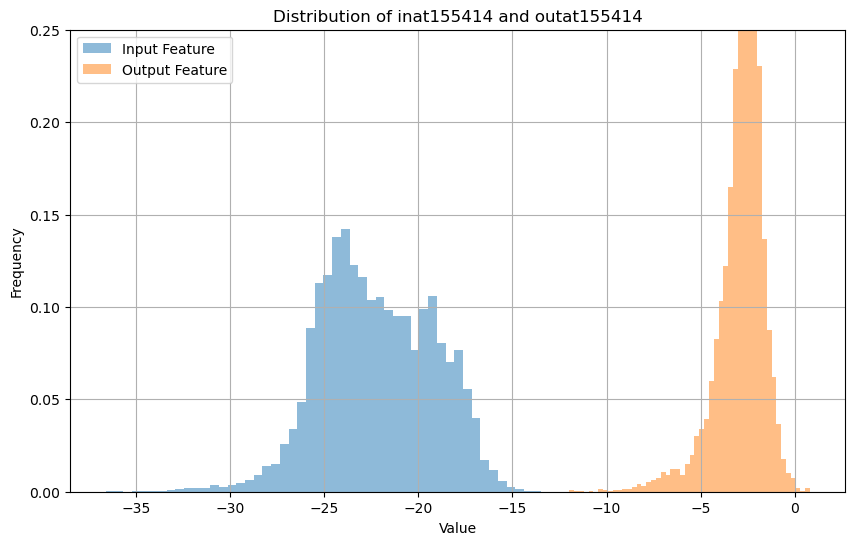

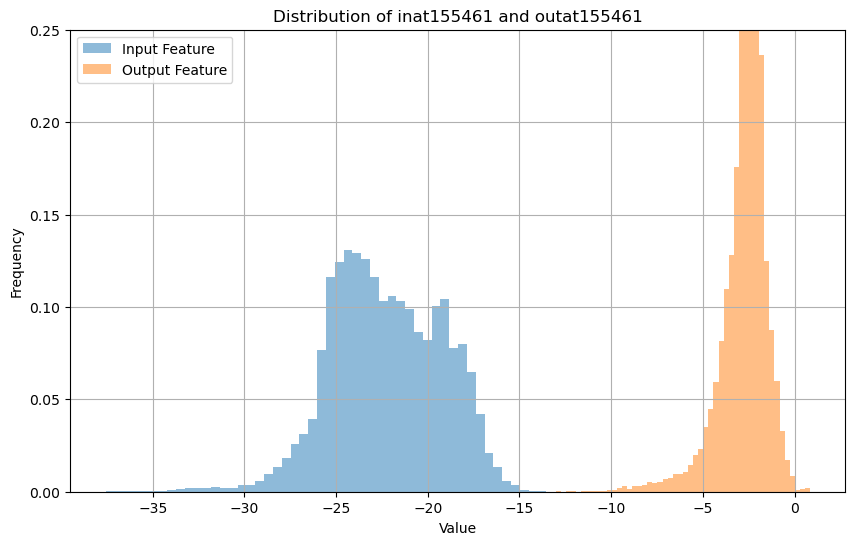

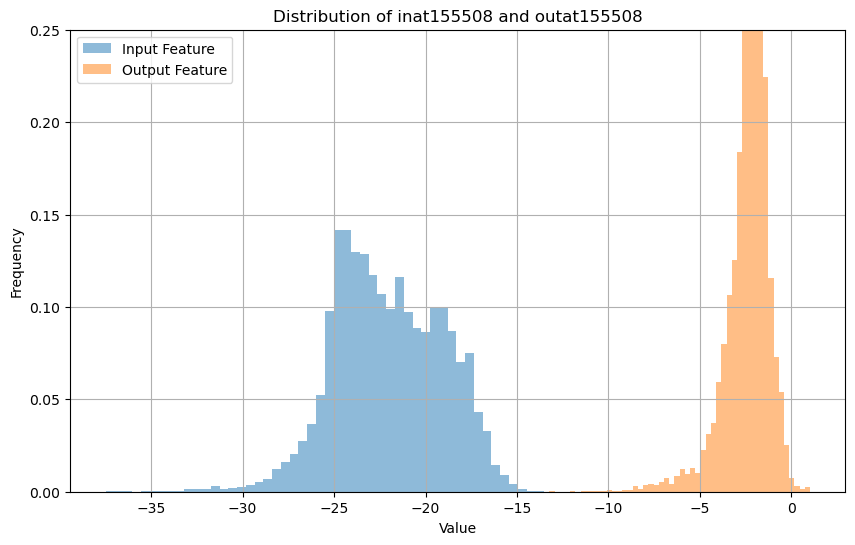

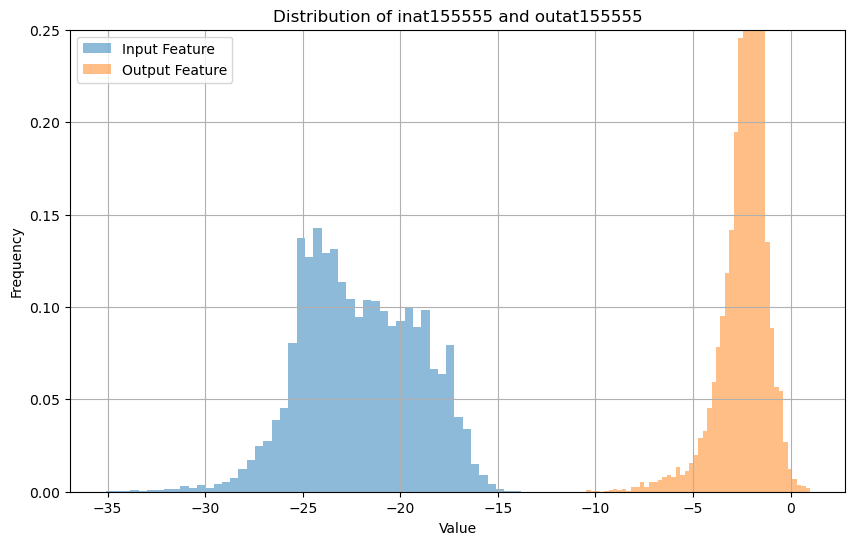

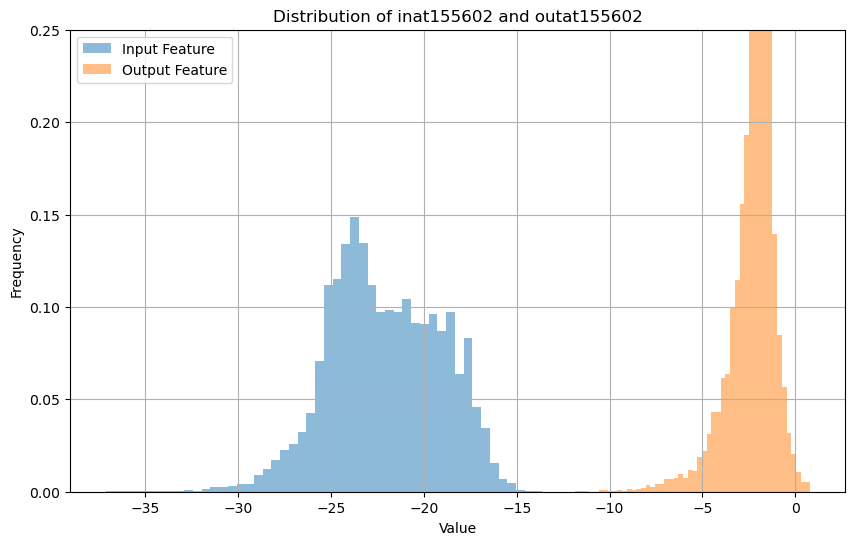

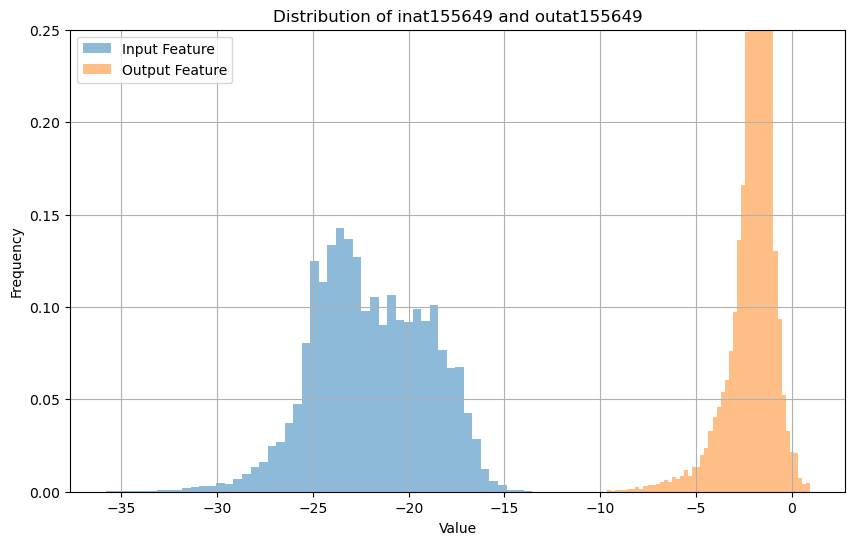

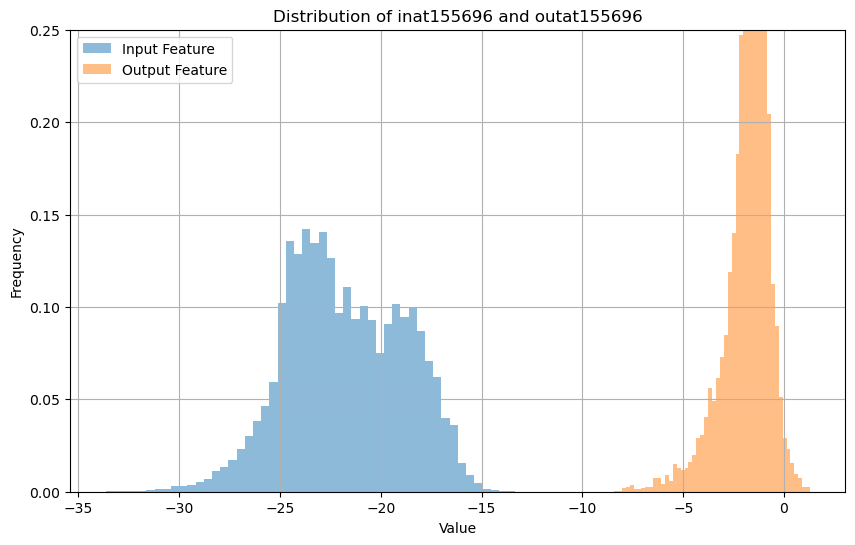

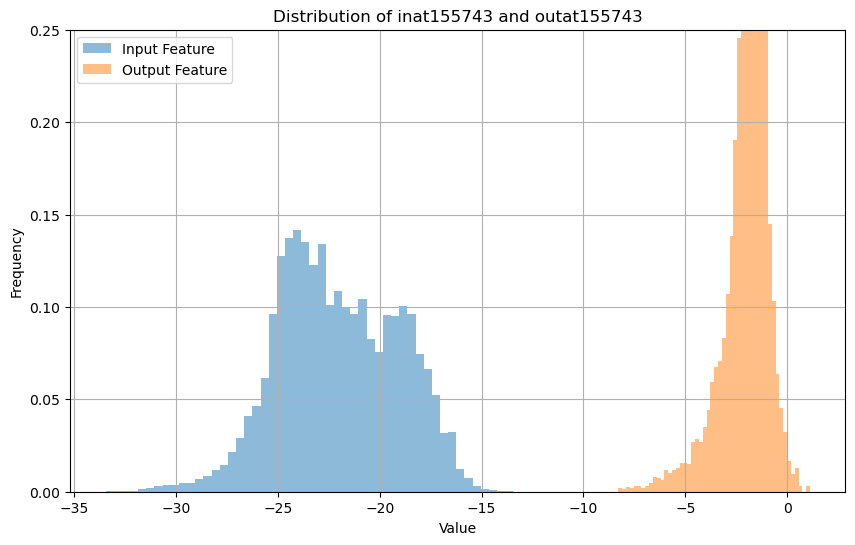

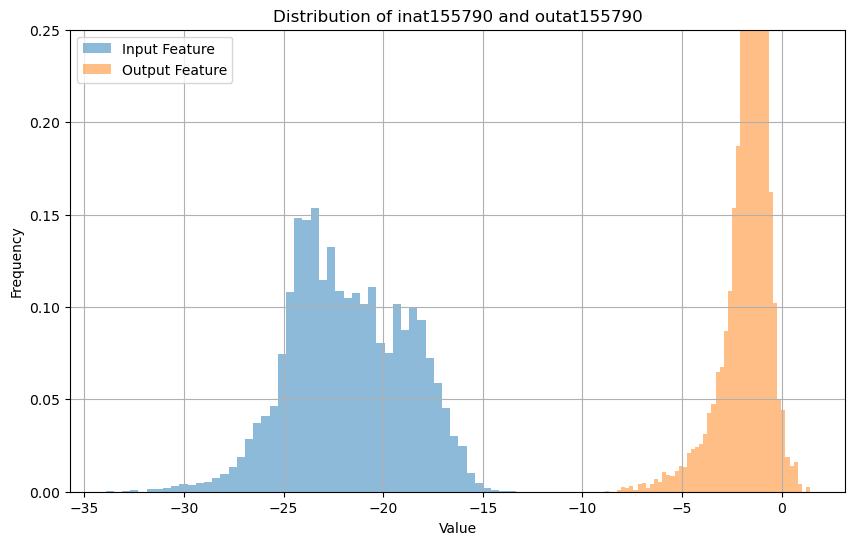

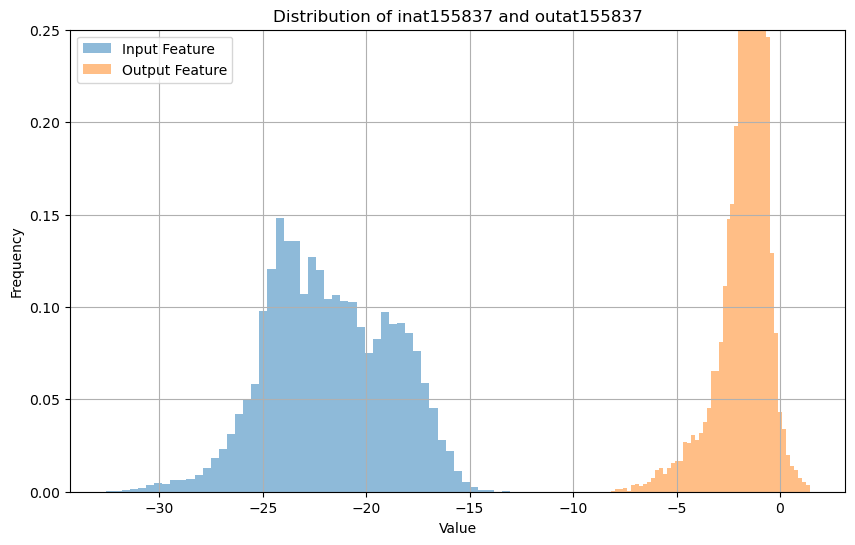

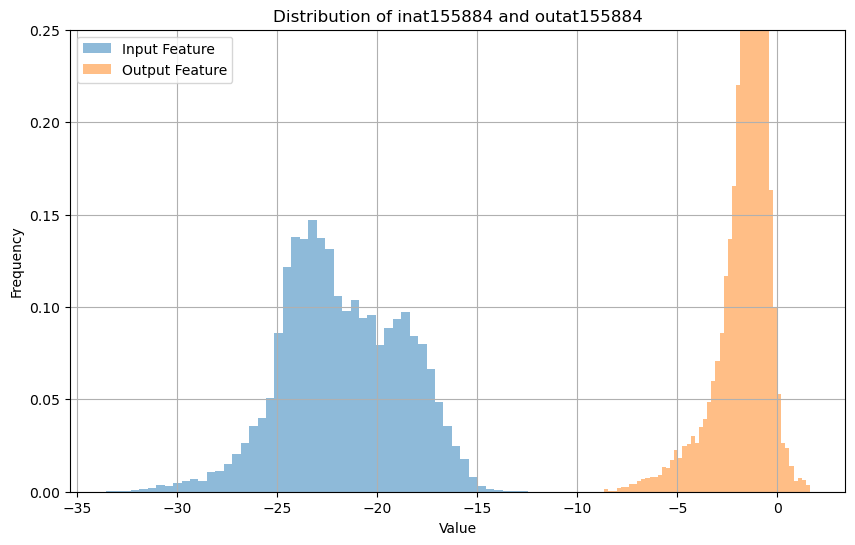

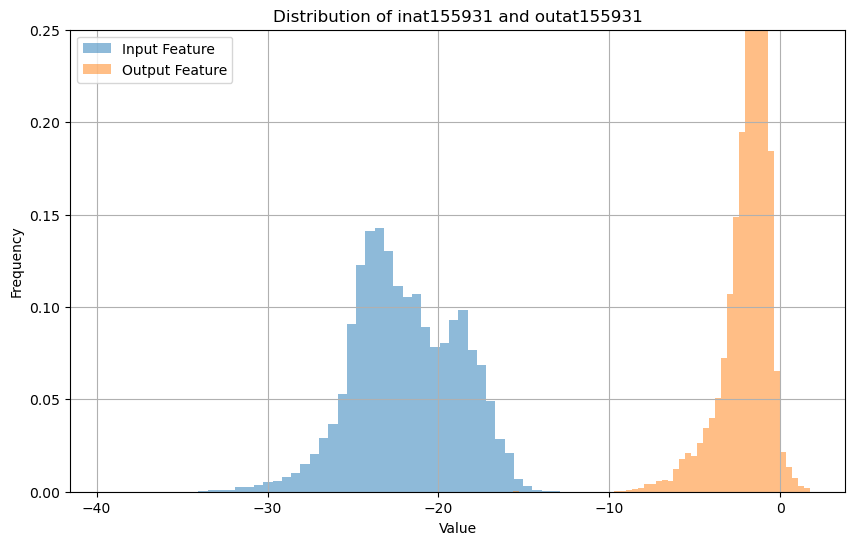

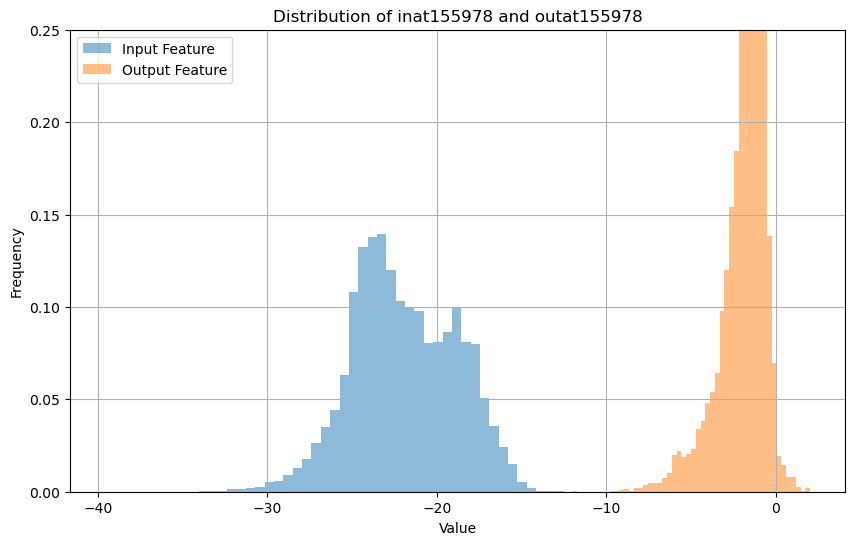

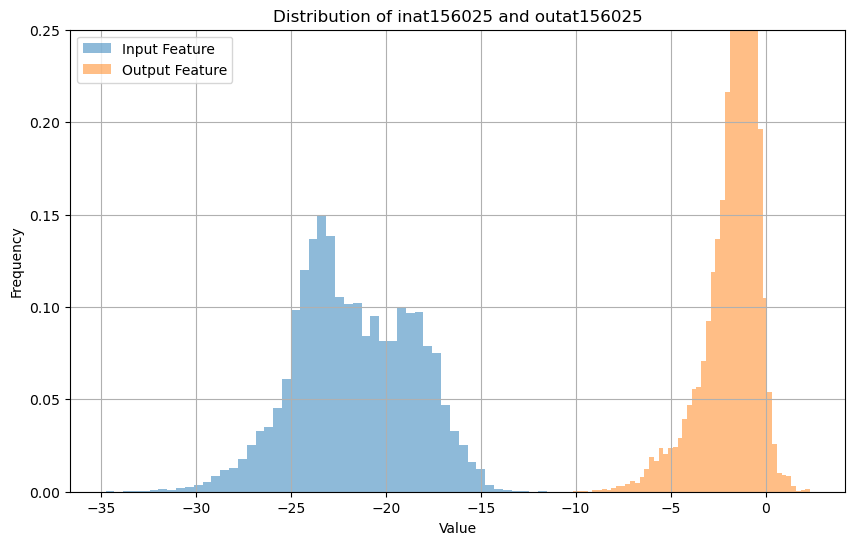

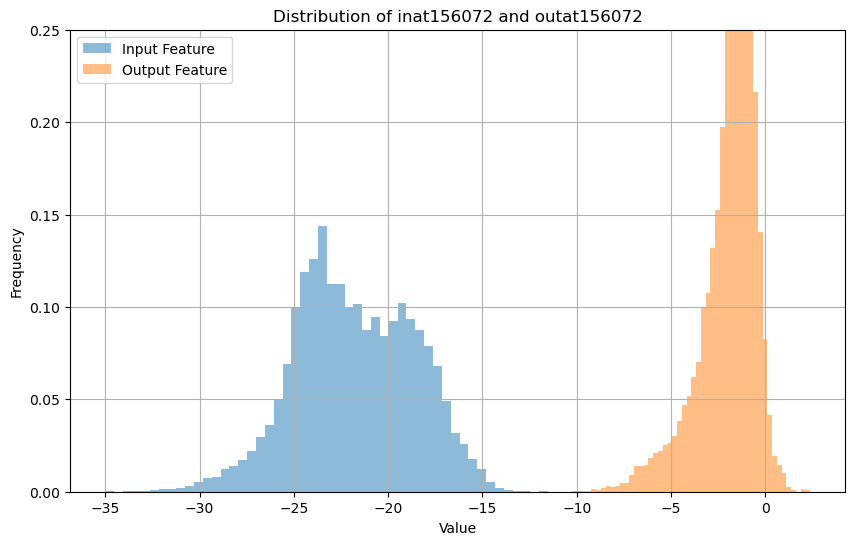

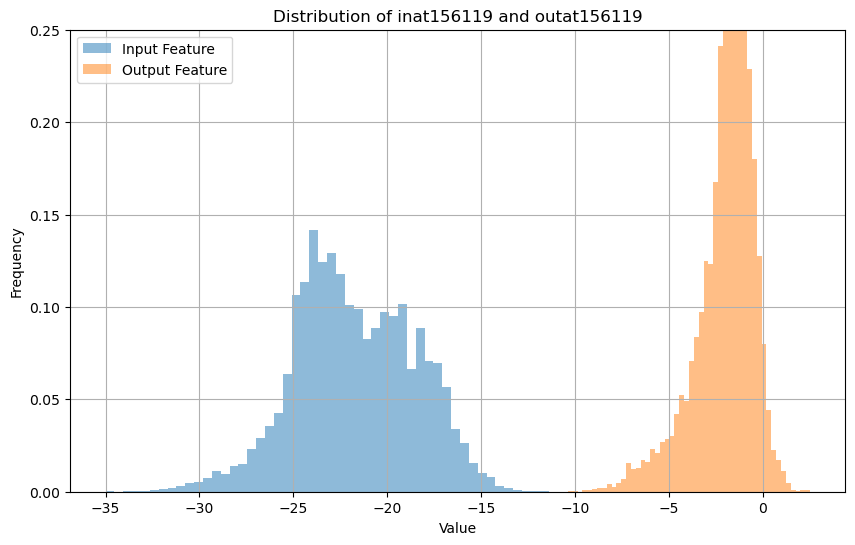

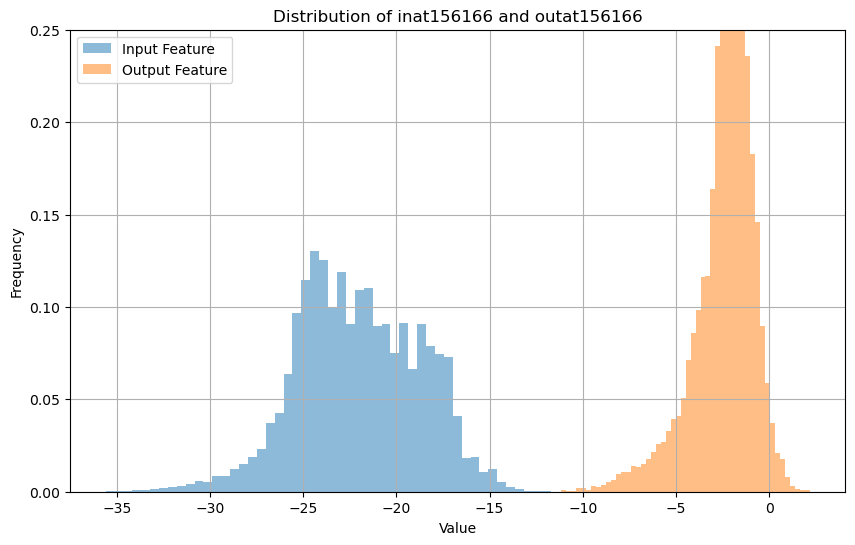

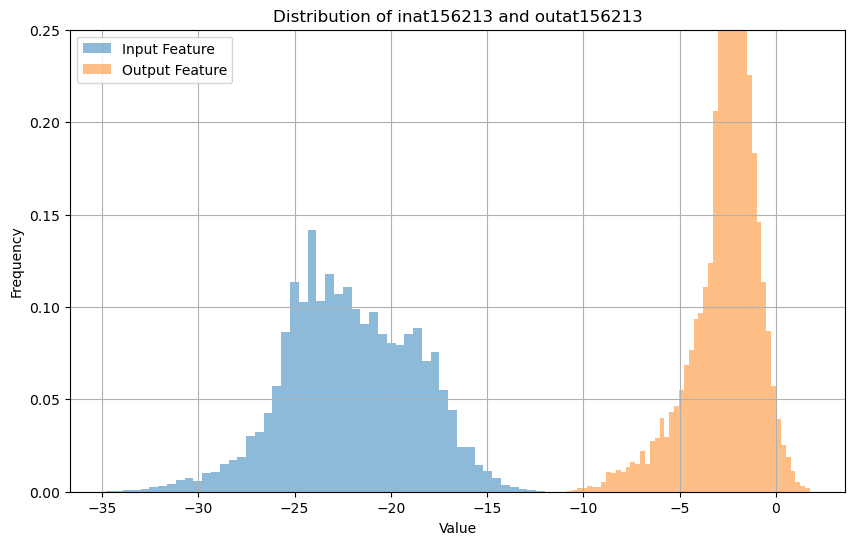

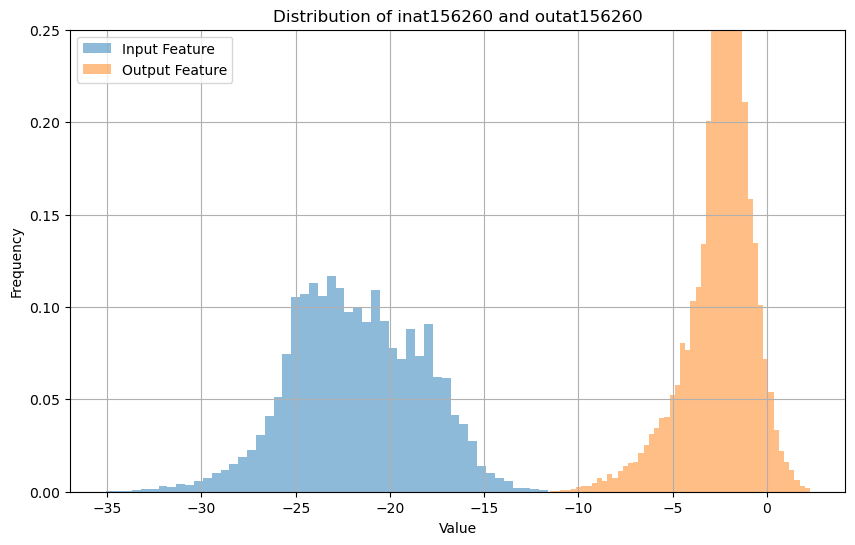

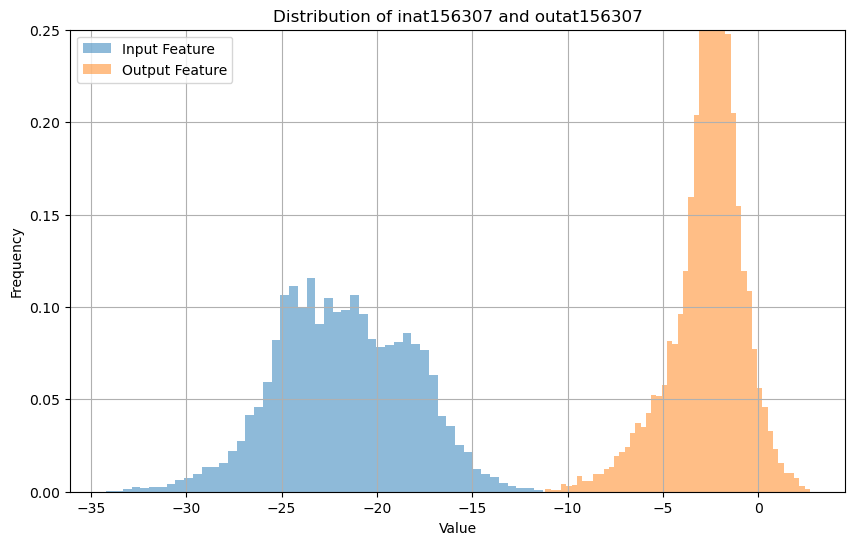

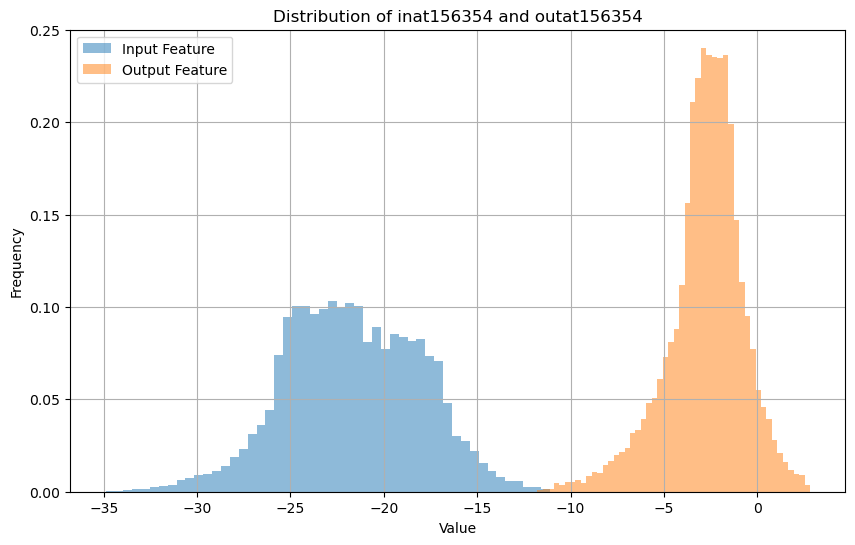

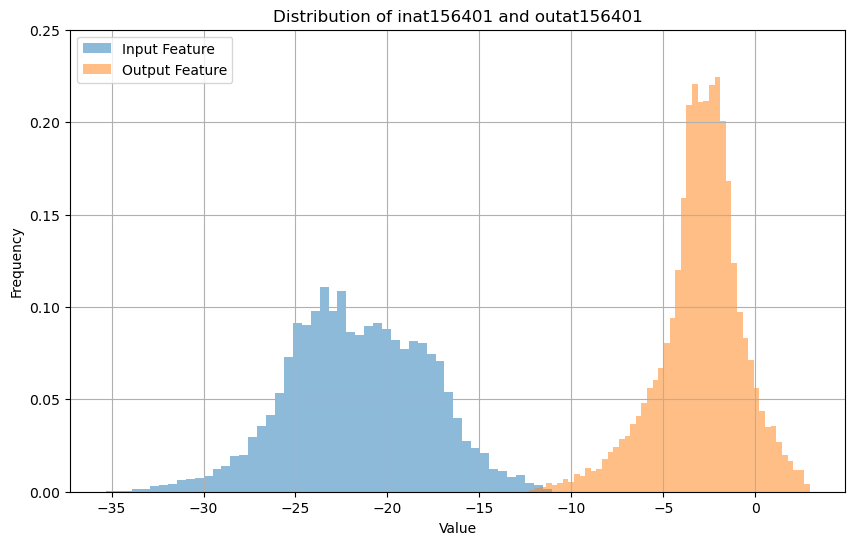

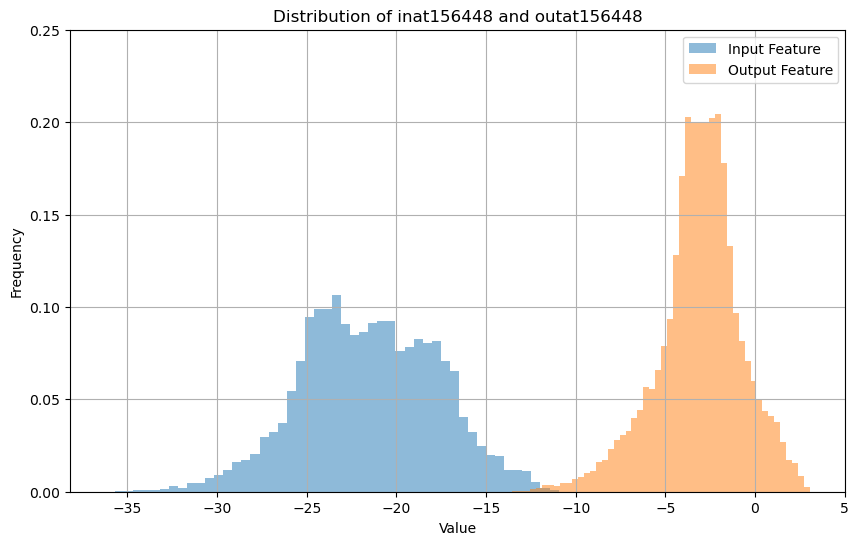

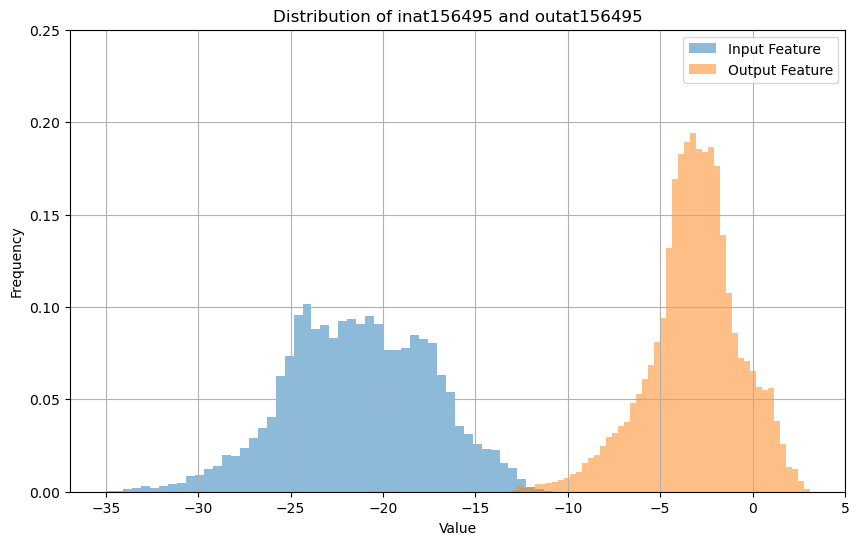

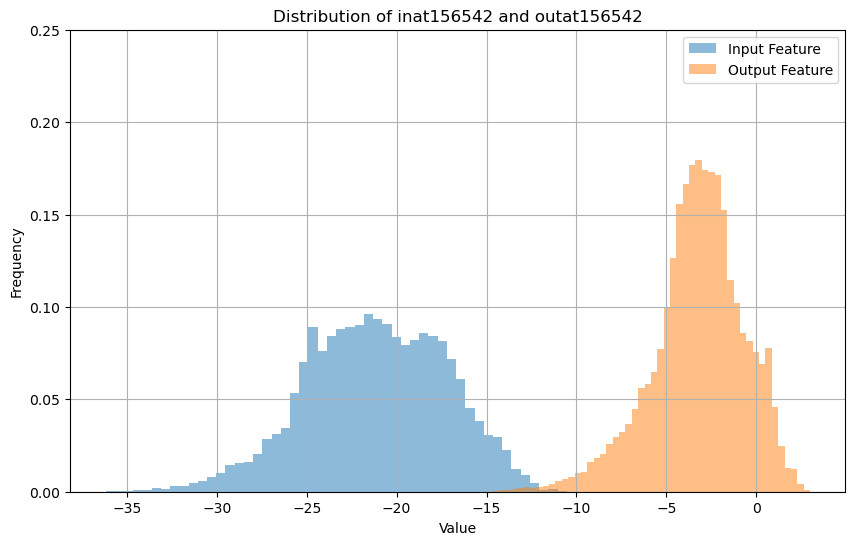

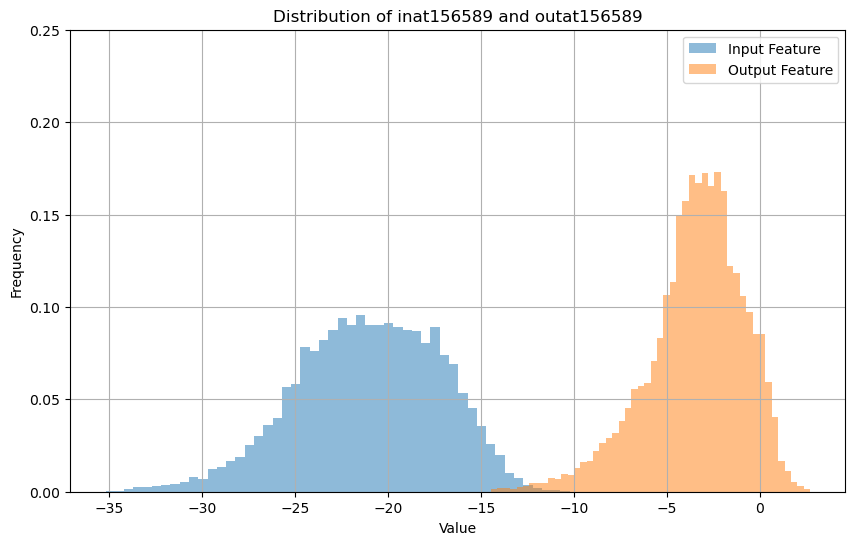

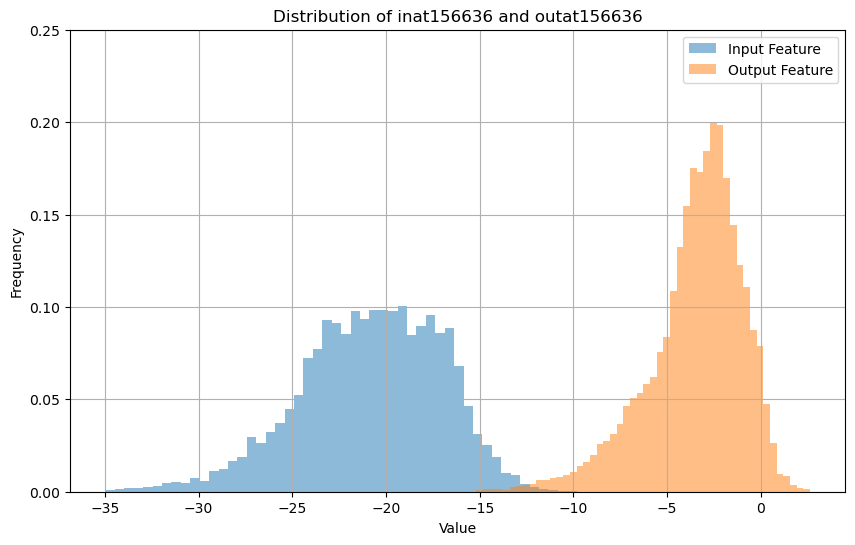

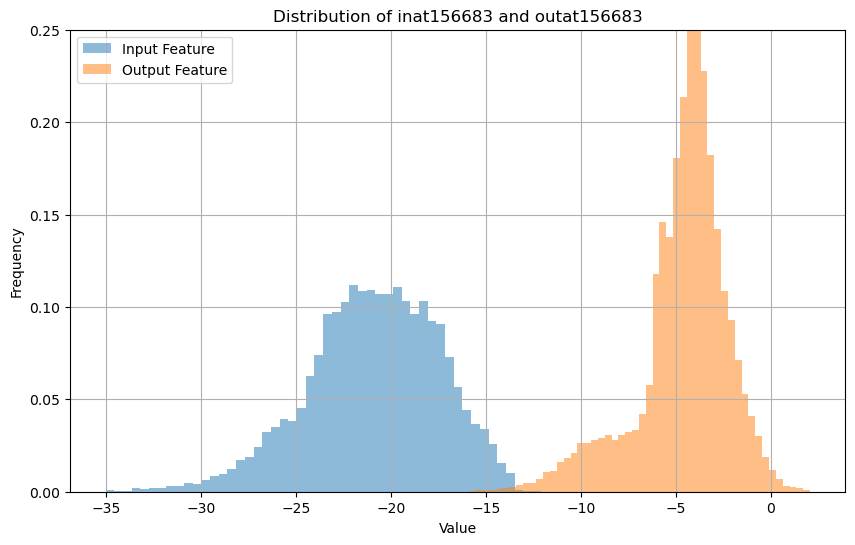

In [ ]:
# Data visualization: Plot the distribution of input and output featuresX_temp, freq_chan = extract_features(raw_data, one_every=1)
X = X_temp[X_temp.columns[2:2+freq_chan]]
y = X_temp[X_temp.columns[-84:]]

# for each column in X, plot the distribution of values (normalized values on y axis)
for colX, colY in zip(X.columns, y.columns):
    plt.figure(figsize=(10, 6))
    plt.hist(X[colX], bins=50, density=True, alpha=0.5, label='Input Feature')
    plt.hist(y[colY], bins=50, density=True, alpha=0.5, label='Output Feature')
    plt.title(f'Distribution of {colX} and {colY}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.ylim(0, 0.25)
    plt.legend()
    plt.grid()
    #plt.show()
    #save the figure
    plt.savefig(f'distributions/{colX}_vs_{colY}.png')